
# PrimateFace Tutorial: Automated Face Recognition Pipeline

| GitHub | Paper | Website |
|---|---|---|
| [Code](https://github.com/KordingLab/PrimateFace) | [Preprint](https://www.biorxiv.org/content/10.1101/2025.08.12.669927v2) | [Project](https://primateface.studio/) |

Welcome! This tutorial notebook demonstrates a complete, closed-set face recognition pipeline. That is, given a set of images with corresponding primate IDs, we will chain together PrimateFace models with off-the-shelf face recognition models to achieve rapid identity recognition.

In this notebook, we use the ['Macaque Faces' dataset published by Witham & Bethell (2019)](https://figshare.com/articles/dataset/Macaque_Faces/9862586).

### This notebook will:

1.  **Set up the environment** with all necessary deep learning libraries (MMDetection, MMPose, InsightFace, Scikit-learn).
2.  **Download pre-trained models** for face detection and facial landmark estimation.
3.  **Load your dataset**, either by creating a mock dataset or by connecting to your own image folder in Google Drive.
4.  **Run the full pipeline:**
    *   **Detect** faces in each image using an MMDetection model.
    *   **Estimate Pose** by finding 68 facial landmarks using an MMPose model.
    *   **Align** and crop each face to a standardized 112x112 size.
    *   **Extract Embeddings** by converting each aligned face into a unique feature vector using an InsightFace (ArcFace) model.
    *   **Train a Classifier** to recognize individuals based on their face embeddings.
5.  **Evaluate Performance** by generating a t-SNE plot, a confusion matrix, and ROC curves.
6.  **Run a Shuffle Control** experiment to validate that the classifier is learning meaningful features.

---
### **Quick Start Instructions**

*   **Set Your Runtime to GPU**: Go to **Runtime > Change runtime type > T4 GPU**. This is essential for performance.
*   **Run Cells Sequentially**: Click the "Play" button on each cell to run it. The initial setup cells can take several minutes.
*   **Restarting**: Installing the dependencies requires restarting the Runtime. You can do this by clicking the "Runtime" menu and selecting "Restart session". After restarting, you must **rerun the setup cells** before continuing.

Let's begin!

## **1. Set up the environment (this will take a few min)**


In [ ]:
#@title Check GPU availability. If not available, change Runtime type to 'T4 GPU'
!nvidia-smi

Tue Aug 19 23:07:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
#@title Fixed installation for Python 3.12
%%capture

# 1. Fix setuptools FIRST
!pip uninstall -y setuptools
!pip install setuptools==70.0.0  # Modern version for Python 3.12

# 2. Clean slate
!pip uninstall -y numpy torch torchvision torchaudio mmcv mmengine mmdet mmpose

# 3. Install numpy
!pip install numpy==1.26.4

# 4. Install PyTorch (use 2.2.0 minimum for Python 3.12)
!pip install torch==2.2.0+cu118 torchvision==0.17.0+cu118 --index-url https://download.pytorch.org/whl/cu118

# 5. Install OpenMMLab stack
!pip install -U openmim
!mim install mmengine==0.10.3
!mim install mmcv==2.1.0
!pip install mmdet==3.3.0

# 6. Install mmpose from source
!rm -rf mmpose
!git clone --depth 1 https://github.com/open-mmlab/mmpose.git
%cd mmpose
!pip install -e .
%cd ..

# 7. Other dependencies
!pip install "opencv-python-headless<4.9" moviepy imageio imageio-ffmpeg
!pip install onnxruntime==1.17.0 insightface==0.7.3

print("✅ Installation complete")

In [ ]:
#@title Install packages (consolidated)
%%capture

# 1. Install uv, a faster pip alternative
!curl -LsSf https://astral.sh/uv/install.sh | sh
!export PATH="/root/.local/bin:$PATH"

# 2. Clean slate (still uses standard pip for uninstall)
!pip uninstall -y numpy xtcocotools pycocotools fastai spacy thinc pymc pytensor jax jaxlib yfinance

# 3. Use uv to install numpy FIRST with --force-reinstall
!uv pip install --force-reinstall --no-deps numpy==1.26.4

# 4. Use uv to install the torch stack
!uv pip install torch==2.1.0+cu118 torchvision==0.16.0+cu118 torchaudio==2.1.0+cu118 --index-url https://download.pytorch.org/whl/cu118

# 5. Use uv to install other major dependencies in a single, consolidated command
!uv pip install \
    "opencv-python-headless<4.9" \
    moviepy==1.0.3 \
    imageio \
    imageio-ffmpeg \
    "numpy==1.26.4" \
    openmim \
    mmdet==3.3.0 \
    onnxruntime==1.17.0 \
    insightface==0.7.3 \
    cython

# 6. Use mim to install MMEngine and MMCV (as recommended by OpenMMLab)
# mim is optimized for resolving OpenMMLab dependencies.
!mim install "mmengine==0.10.3" "numpy==1.26.4"
!mim install "mmcv==2.1.0" "numpy==1.26.4"

# 7. Clone mmpose using a shallow clone and install its requirements with uv
!rm -rf mmpose
!git clone --depth 1 https://github.com/open-mmlab/mmpose.git
%cd mmpose
!uv pip install -e . --no-deps
!uv pip install -r requirements.txt "numpy==1.26.4"
%cd ..

# 8. Build xtcocotools from source against the correct numpy version using uv
!uv pip install --no-binary :all: xtcocotools

print("✅ All packages installed successfully!")

In [ ]:
#@title (takes 1 min) Install PyTorch, mmdet, mmpose, and Insightface with strict numpy pinning
%%capture
# 1. Clean slate
!pip uninstall -y numpy xtcocotools pycocotools fastai spacy thinc pymc pytensor jax jaxlib yfinance

# 2. Install numpy FIRST with --force-reinstall
!pip install --force-reinstall --no-deps numpy==1.26.4

# 3. Install torch stack (won't touch numpy)
!pip install torch==2.1.0+cu118 torchvision==0.16.0+cu118 torchaudio==2.1.0+cu118 --index-url https://download.pytorch.org/whl/cu118

# 4. Install other deps with numpy constraint
!pip install --no-cache-dir "opencv-python-headless<4.9" moviepy==1.0.3 imageio imageio-ffmpeg "numpy==1.26.4"

# 5. Install MMDet/MMPose deps with constraints
!pip install -U openmim "numpy==1.26.4"
!mim install "mmengine==0.10.3" "numpy==1.26.4"
!mim install "mmcv==2.1.0" "numpy==1.26.4"

# 6. Clone and install mmpose
!rm -rf mmpose
!git clone https://github.com/open-mmlab/mmpose.git
%cd mmpose
!pip install -e . --no-deps
!pip install -r requirements.txt "numpy==1.26.4"
%cd ..

# 7. Install mmdet with constraint
!pip install mmdet==3.3.0 "numpy==1.26.4"

# 8. Build xtcocotools from source against correct numpy
!pip install cython
!pip install --no-binary :all: xtcocotools

# 9. InsightFace
!pip install onnxruntime==1.17.0 insightface==0.7.3 "numpy==1.26.4"

#@title Install backend pytorch versions and confirm GPU availability.
# %%capture
# !pip uninstall -y fastai spacy thinc pymc pytensor jax jaxlib yfinance

# # 2. Pin the scientific stack *before* installing torch
# !pip install --no-cache-dir "numpy==1.26.4" \
#                "opencv-python-headless<4.9" moviepy==1.0.3 \
#                imageio imageio-ffmpeg

# !pip install torch==2.1.0+cu118 torchvision==0.16.0+cu118 torchaudio==2.1.0+cu118 --index-url https://download.pytorch.org/whl/cu118

# ## ---
# import torch
# print(torch.__version__, torch.version.cuda)
# print("CUDA available:", torch.cuda.is_available())
# print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "-")

# #@title Install MMDetection, MMPose, and InsightFace dependencies
# %%capture
# %pip install -U openmim
# !mim install "mmengine==0.10.3"
# !mim install "mmcv==2.1.0"

# # Install mmdetection
# # !rm -rf mmdetection
# # !git clone https://github.com/open-mmlab/mmdetection.git
# # %cd mmdetection
# # %pip install -e .
# # %cd ..

# # Install mmpose
# !rm -rf mmpose
# !git clone https://github.com/open-mmlab/mmpose.git
# %cd mmpose
# %pip install -e .
# %cd ..

# !pip install mmdet==3.3.0

# # Install InsightFace
# !pip install onnxruntime==1.17.0 insightface==0.7.3

### Now '**restart**' the session.

To fully use the newly installed packages, we need to restart the colab notebook runtime.

1.  Click **Runtime** > **Restart session**
2.  Rerun the setup cells above.
3.  Continue with the rest of the notebook.

In [ ]:
#@title Re-install after restart (required)
import subprocess
result = subprocess.run(['python', '-c', 'import mmcv'], capture_output=True)
if result.returncode != 0:
    print("🔄 Reinstalling packages after restart...")
    # Run your full installation here
    # 1. Clean slate
    !pip uninstall -y numpy xtcocotools pycocotools fastai spacy thinc pymc pytensor jax jaxlib yfinance

    # 2. Install numpy FIRST with --force-reinstall
    !pip install --force-reinstall --no-deps numpy==1.26.4

    # 3. Install torch stack (won't touch numpy)
    !pip install torch==2.1.0+cu118 torchvision==0.16.0+cu118 torchaudio==2.1.0+cu118 --index-url https://download.pytorch.org/whl/cu118

    # 4. Install other deps with numpy constraint
    !pip install --no-cache-dir "opencv-python-headless<4.9" moviepy==1.0.3 imageio imageio-ffmpeg "numpy==1.26.4"

    # 5. Install MMDet/MMPose deps with constraints
    !pip install -U openmim "numpy==1.26.4"
    !mim install "mmengine==0.10.3" "numpy==1.26.4"
    !mim install "mmcv==2.1.0" "numpy==1.26.4"

    # 6. Clone and install mmpose
    !rm -rf mmpose
    !git clone https://github.com/open-mmlab/mmpose.git
    %cd mmpose
    !pip install -e . --no-deps
    !pip install -r requirements.txt "numpy==1.26.4"
    %cd ..

    # 7. Install mmdet with constraint
    !pip install mmdet==3.3.0 "numpy==1.26.4"

    # 8. Build xtcocotools from source against correct numpy
    !pip install cython
    !pip install --no-binary :all: xtcocotools

    # 9. InsightFace
    !pip install onnxruntime==1.17.0 insightface==0.7.3 "numpy==1.26.4"  # or paste the installation code
else:
    print("✅ Packages intact")

🔄 Reinstalling packages after restart...
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)


Looking in indexes: https://download.pytorch.org/whl/cu118
ERROR: Could not find a version that satisfies the requirement torch==2.1.0+cu118 (from versions: 2.2.0+cu118, 2.2.1+cu118, 2.2.2+cu118, 2.3.0+cu118, 2.3.1+cu118, 2.4.0+cu118, 2.4.1+cu118, 2.5.0+cu118, 2.5.1+cu118, 2.6.0+cu118, 2.7.0+cu118, 2.7.1+cu118)
ERROR: No matching distribution found for torch==2.1.0+cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 181.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.8 requires opencv-python-headless>=4.9.0.80, but you have opencv-python-headless 4.8.1.78 which is incompatible.
albucore 0.

In [ ]:
#@title Import libraries for the analysis pipeline
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from pathlib import Path
from PIL import Image
import requests
import io
import itertools
from tqdm.notebook import tqdm
import os
import shutil
import glob
from typing import List, Tuple, Dict, Any
import cv2
import argparse

from mmdet.apis import init_detector, inference_detector
from mmengine.utils import check_file_exist
from mmengine.config import Config

from mmpose.apis import init_model as init_mmpose_model, inference_topdown
from mmpose.structures import merge_data_samples as merge_mmpose_data_samples
from mmpose.utils import adapt_mmdet_pipeline
from insightface.model_zoo import get_model
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.utils import shuffle as sk_shuffle

# For displaying results
from IPython.display import display, Image as IPImage


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.12/dist-package

ModuleNotFoundError: No module named 'mmcv'

## **2. Download Models & Set Up Functions**

Here, we'll download the pre-trained models needed for our pipeline:
1.  **Face Detector**: An MMDetection model to find faces in images.
2.  **Pose Estimator**: An MMPose model to find 68 key facial landmarks.

The **Face Recognizer** (InsightFace) will be downloaded automatically by its library in the next step.


In [ ]:
%%capture
#@title Download PrimateFace Detection & Pose Models

# --- MMDetection Model ---
MMDET_CONFIG_GDRIVE_LINK = "https://drive.google.com/file/d/1Y_YFdIDRcWQLI-gRiCnOrDxCptzCiiNp/view?usp=drive_link"
MMDET_CHECKPOINT_GDRIVE_LINK = "https://drive.google.com/file/d/1zZ8S31zPHX5BWYKbnHxI1QOqP-fPnVFO/view?usp=drive_link"

# --- MMPose Model ---
MMPOSE_CONFIG_GDRIVE_LINK = "https://drive.google.com/file/d/1sG2lLybRkLwmC0IkEqtEGuT1OxwXomju/view?usp=drive_link"
MMPOSE_CHECKPOINT_GDRIVE_LINK = "https://drive.google.com/file/d/1Oa18Ty90bNE8fud0cuK3gZmPY_LAQo3Y/view?usp=sharing"


import gdown
import os
from pathlib import Path

# --- Define local filenames ---
MMDET_CONFIG_PATH = "downloaded_mmdet_config.py"
MMDET_CHECKPOINT_PATH = "downloaded_mmdet_weights.pth"
MMPOSE_CONFIG_PATH = "downloaded_mmpose_config.py"
MMPOSE_CHECKPOINT_PATH = "downloaded_mmpose_weights.pth"

# --- Download function ---
def download_file_from_gdrive(url, output_path):
    print(f"Downloading to {output_path}...")
    try:
        gdown.download(url, output_path, quiet=False, fuzzy=True)
        if os.path.exists(output_path):
            print(f"Success: {output_path}\n")
            return True
        else:
            print(f"Fail: {output_path}. Check link and permissions.\n")
            return False
    except Exception as e:
        print(f"Error downloading {output_path}: {e}\n")
        return False

# --- Execute downloads ---
download_file_from_gdrive(MMDET_CONFIG_GDRIVE_LINK, MMDET_CONFIG_PATH)
download_file_from_gdrive(MMDET_CHECKPOINT_GDRIVE_LINK, MMDET_CHECKPOINT_PATH)
download_file_from_gdrive(MMPOSE_CONFIG_GDRIVE_LINK, MMPOSE_CONFIG_PATH)
download_file_from_gdrive(MMPOSE_CHECKPOINT_GDRIVE_LINK, MMPOSE_CHECKPOINT_PATH)

In [ ]:
%%capture
#@title Load the Arcface recognition model from the [InsightFace python library](https://github.com/deepinsight/insightface/tree/554a05561cb71cfebb4e012dfea48807f845a0c2)
# 0. Global-style utility & Figure Saving

# --- Initialize InsightFace recognition model globally using FaceAnalysis app ---
print("\nInitializing InsightFace recognition model via FaceAnalysis app...")

# We will define the global 'app' and 'rec_model' here for the whole notebook
app = None
rec_model = None

from insightface.app import FaceAnalysis

try:
    # This is the more reliable way for Colab
    app = FaceAnalysis(name='buffalo_l', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
    app.prepare(ctx_id=0, det_size=(640, 640))

    # Access the recognition model from the app and assign it to the global rec_model
    if hasattr(app, 'models') and 'recognition' in app.models:
        rec_model = app.models['recognition']
        print("InsightFace app and recognition model loaded successfully.")
        if hasattr(rec_model, 'session') and hasattr(rec_model.session, 'get_providers'):
            print(f"ONNX session active providers: {rec_model.session.get_providers()}")
    else:
        print("ERROR: Recognition model not found in FaceAnalysis app.models")

except Exception as e:
    print(f"CRITICAL ERROR: Could not load InsightFace model via FaceAnalysis: {e}")
    print("The rest of the pipeline will likely fail.")

# Note: The MMPose model paths are defined later in the notebook after they are downloaded.
# We remove the old hardcoded paths from this cell.

In [ ]:
#@title Helper Functions (Detection, Alignment, Training, Plotting)

# --- Facial Landmark Constants for Alignment ---
LANDMARK_INDICES_68PT_FOR_5PT_ALIGNMENT = {
    'left_eye_indices': list(range(36, 42)),
    'right_eye_indices': list(range(42, 48)),
    'nose_tip_idx': 30,
    'left_mouth_corner_idx': 48,
    'right_mouth_corner_idx': 54
}
TARGET_LANDMARKS_5PT_112X112 = np.array([
    [38.2946, 51.6963], [73.5318, 51.5014], [56.0252, 71.7366],
    [41.5493, 92.3655], [70.7299, 92.2041]
], dtype=np.float32)

# 0. Global-style utility & Figure Saving
def save_fig(fig, name: str, out_dir='figures', dpi=300):
    """Saves the figure in both PDF and PNG formats."""
    output_path = Path(out_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_path / f'{name}.pdf', bbox_inches='tight')
    fig.savefig(output_path / f'{name}.png', dpi=dpi, bbox_inches='tight')
    print(f"Figure saved to {output_path}/{name}.pdf and .png")

def setup_global_styles_and_seeds():
    """Sets up global Matplotlib styles and random seeds."""
    plt.rcParams.update({
        "font.family": "sans-serif", "font.size": 8,
        "savefig.dpi": 300, "figure.dpi": 150,
        "axes.spines.right": False, "axes.spines.top": False,
        'xtick.labelsize': 8, 'ytick.labelsize': 8,
        'axes.labelsize': 9
    })
    global rng, PALETTE
    rng = np.random.default_rng(0)
    random.seed(0)
    torch.manual_seed(0)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(0)
    PALETTE = plt.cm.tab20.colors
    print("Global styles and random seeds configured.")

# Call setup at the beginning
setup_global_styles_and_seeds()

# --- MMPose Model Loading ---
mmpose_model = None
mmpose_device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

def load_mmpose_model():
    """Initializes the MMPose model."""
    global mmpose_model
    if not Path(MMPOSE_CONFIG_PATH).exists() or not Path(MMPOSE_CHECKPOINT_PATH).exists():
        print("MMPose model files not found. Please run the download cell.")
        return
    try:
        print(f"Initializing MMPose model...")
        cfg_options = dict(model=dict(test_cfg=dict(output_heatmaps=False)))
        mmpose_model = init_mmpose_model(
            MMPOSE_CONFIG_PATH, MMPOSE_CHECKPOINT_PATH,
            device=mmpose_device, cfg_options=cfg_options
        )
        print(f"MMPose model loaded successfully on {mmpose_device}.")
    except Exception as e:
        print(f"MMPose model loading error → {e}")
        mmpose_model = None



def get_5_source_landmarks_from_68(landmarks_68: np.ndarray) -> np.ndarray:
    """Extracts 5 source landmarks from a 68-point set."""
    src_pts = np.zeros((5, 2), dtype=np.float32)
    src_pts[0] = np.mean(landmarks_68[LANDMARK_INDICES_68PT_FOR_5PT_ALIGNMENT['left_eye_indices'], :2], axis=0)
    src_pts[1] = np.mean(landmarks_68[LANDMARK_INDICES_68PT_FOR_5PT_ALIGNMENT['right_eye_indices'], :2], axis=0)
    src_pts[2] = landmarks_68[LANDMARK_INDICES_68PT_FOR_5PT_ALIGNMENT['nose_tip_idx'], :2]
    src_pts[3] = landmarks_68[LANDMARK_INDICES_68PT_FOR_5PT_ALIGNMENT['left_mouth_corner_idx'], :2]
    src_pts[4] = landmarks_68[LANDMARK_INDICES_68PT_FOR_5PT_ALIGNMENT['right_mouth_corner_idx'], :2]
    return src_pts

def align_face_5pts(image_bgr: np.ndarray, source_landmarks_5pts: np.ndarray) -> np.ndarray:
    """Aligns a face using 5 landmarks via an affine transformation."""
    target_size = (112, 112)
    try:
        transform_matrix, _ = cv2.estimateAffinePartial2D(source_landmarks_5pts, TARGET_LANDMARKS_5PT_112X112, method=cv2.LMEDS)
        if transform_matrix is None: return None
        aligned_face_bgr = cv2.warpAffine(image_bgr, transform_matrix, target_size, borderValue=(0, 0, 0))
        return aligned_face_bgr
    except Exception as e:
        return None

# --- Image Augmentation ---
def augment_brightness_contrast(image_bgr: np.ndarray) -> np.ndarray:
    """Applies random brightness and contrast augmentation."""
    brightness_offset = random.randint(-30, 30)
    contrast_factor = random.uniform(0.85, 1.15)
    augmented_image = image_bgr.astype(np.float32) * contrast_factor + brightness_offset
    return np.clip(augmented_image, 0, 255).astype(np.uint8)

# --- Embedding Extraction ---
def get_embedding(image_bgr: np.ndarray) -> np.ndarray:
    """Gets embedding using the global rec_model."""
    if rec_model is None: raise RuntimeError("InsightFace model not initialized.")
    if image_bgr.shape[:2] != (112, 112):
        image_bgr = cv2.resize(image_bgr, (112, 112))
    return rec_model.get_feat(image_bgr)

# --- Dataset Functions ---


def load_user_images_and_assign_ids(
    user_img_dir: Path,
    min_samples_per_id: int = 3
) -> Tuple[List[Path], List[str], List[str]]:
    """
    Scans, filters, and loads images using a two-pass method.
    1. Extracts all valid image paths and their IDs into flat lists.
    2. Counts IDs and determines which ones meet the min_samples requirement.
    3. Creates the final lists by filtering the initial flat lists.
    """
    print(f"Scanning for images in {user_img_dir}...")
    allowed_extensions = [".jpg", ".jpeg", ".png"]
    all_image_paths = sorted([p for p in user_img_dir.glob("*") if p.suffix.lower() in allowed_extensions])

    # --- Step 1: First pass to get all valid paths and IDs ---
    initial_paths = []
    initial_ids = []
    for p in all_image_paths:
        stem = p.stem
        if '_' in stem and '-' in stem:
            try:
                after_underscore = stem.split('_', 1)[1]
                the_id = after_underscore.split('-', 1)[0]
                if the_id:
                    initial_paths.append(p)
                    initial_ids.append(the_id)
            except IndexError:
                continue
    print(f"Found {len(initial_paths)} images across {len(set(initial_ids))} initial unique IDs.")

    if not initial_paths:
        print("CRITICAL ERROR: No valid images found matching the format.")
        return [], [], []

    # --- Step 2: Count IDs and find which ones are valid ---
    id_counts = collections.Counter(initial_ids)
    valid_ids_set = {
        the_id for the_id, count in id_counts.items()
        if count >= min_samples_per_id
    }
    print(f"Found {len(valid_ids_set)} IDs with at least {min_samples_per_id} samples each.")

    # --- Step 3: Second pass to build the final filtered lists ---
    final_source_paths = []
    final_assigned_ids = []
    for i in range(len(initial_ids)):
        if initial_ids[i] in valid_ids_set:
            final_source_paths.append(initial_paths[i])
            final_assigned_ids.append(initial_ids[i])

    unique_ids_final = sorted(list(set(final_assigned_ids)))
    print(f"\n---> Final dataset for pipeline: {len(final_source_paths)} images from {len(unique_ids_final)} individuals.")
    print(f"First 5 unique IDs being used: {unique_ids_final[:5]}")

    return final_source_paths, final_assigned_ids, unique_ids_final

def create_mock_dataset(root_dir_name="primate_demo", num_ids=12, images_per_id=18):
    """Creates a mock dataset of images."""
    print("Creating mock dataset...")
    root = Path(root_dir_name)
    raw_dir = root / "raw"
    raw_dir.mkdir(parents=True, exist_ok=True)
    IDS = [f"id_{i:02d}" for i in range(num_ids)]
    for pid in tqdm(IDS, desc="Generating mock images"):
        id_dir = raw_dir / pid
        id_dir.mkdir(exist_ok=True)
        for k in range(images_per_id):
            try:
                img = Image.open(io.BytesIO(requests.get("https://picsum.photos/256", timeout=5).content))
                img.save(id_dir / f"{k:04d}.jpg")
            except Exception as e:
                placeholder_img = Image.new('RGB', (256, 256), color='grey')
                placeholder_img.save(id_dir / f"{k:04d}.jpg")
    print("Mock dataset created.")
    return root, IDS

# --- Pipeline Functions ---
def detect_and_crop_faces(detector_model: Any, original_image_paths: List[Path], assigned_ids_for_images: List[str], base_output_dir: Path, device='cuda:0'):
    """Detects, aligns, and crops faces. (Updated to handle different data types)"""
    print("Detecting, aligning, and cropping faces...")
    if detector_model is None or mmpose_model is None:
        print("ERROR: Detection or Pose model not loaded. Skipping.")
        return None

    # Helper to safely convert to numpy
    def to_numpy(data):
      if torch.is_tensor(data):
        return data.cpu().numpy()
      return data

    crop_dir = base_output_dir / "crops"
    crop_dir.mkdir(parents=True, exist_ok=True)

    for im_path, assigned_id in tqdm(zip(original_image_paths, assigned_ids_for_images), total=len(original_image_paths), desc="Detecting & Aligning"):
        try:
            original_img_bgr = cv2.imread(str(im_path))
            if original_img_bgr is None: continue

            out_mmdet = inference_detector(detector_model, original_img_bgr)
            pred_instances = out_mmdet.pred_instances

            if len(pred_instances) == 0: continue

            # The bboxes and scores might be tensors or numpy arrays
            scores = to_numpy(pred_instances.scores)
            bboxes = to_numpy(pred_instances.bboxes)

            best_bbox_idx = scores.argmax()
            best_bbox = bboxes[best_bbox_idx]

            # The inference_topdown function expects a numpy bbox
            pose_results = inference_topdown(mmpose_model, original_img_bgr, [best_bbox], bbox_format='xyxy')

            if not pose_results or not hasattr(pose_results[0].pred_instances, 'keypoints'): continue

            # The keypoints might be tensors or numpy arrays
            landmarks_68 = to_numpy(pose_results[0].pred_instances.keypoints[0])

            if landmarks_68.shape[0] != 68: continue

            source_5pts = get_5_source_landmarks_from_68(landmarks_68)
            aligned_bgr = align_face_5pts(original_img_bgr, source_5pts)

            if aligned_bgr is not None:
                aligned_pil = Image.fromarray(cv2.cvtColor(aligned_bgr, cv2.COLOR_BGR2RGB))
                save_p = crop_dir / f"{assigned_id}_{im_path.stem}_face_aligned.jpg"
                aligned_pil.save(save_p)
        except Exception as e:
            print(f"Error processing {im_path}: {e}")

    print(f"Aligned face crops saved to {crop_dir}")
    return crop_dir

def extract_embeddings_direct(crop_dir: Path):
    """Extracts embeddings from aligned face crops."""
    print("Extracting embeddings...")
    if rec_model is None:
        print("ERROR: Recognition model not initialized.")
        return None, None, None

    feats, labels, paths_list = [], [], []
    crop_files = sorted(list(crop_dir.glob("*_face_aligned.jpg")))

    for p_crop in tqdm(crop_files, desc="Extracting Embeddings"):
        try:
            bgr_img = cv2.imread(str(p_crop))
            if bgr_img is None: continue
            emb = get_embedding(bgr_img)
            if emb is not None:
                feats.append(emb)
                labels.append(p_crop.stem.split('_')[0] + "_" + p_crop.stem.split('_')[1])
                paths_list.append(str(p_crop))
        except Exception as e:
            print(f"Embedding failed for {p_crop.name}: {e}")

    if not feats:
        print("No embeddings extracted.")
        return None, None, None

    X_embed = np.vstack(feats)
    y_labels = np.array(labels)
    img_paths = np.array(paths_list)

    np.savez("embeddings.npz", X=X_embed, y=y_labels, paths=img_paths)
    print(f"Embeddings saved to embeddings.npz. Shape: {X_embed.shape}")
    return X_embed, y_labels, img_paths

def train_classifier(X_embed_all, y_labels_all, img_paths_all, augment=True):
    """
    Trains and evaluates SVM and MLP classifiers using GridSearchCV for robust hyperparameter tuning.
    """
    print("Training ID classifiers with GridSearchCV...")

    le = LabelEncoder()
    y_labels_encoded = le.fit_transform(y_labels_all)

    # Split data into training and testing sets first
    X_tr_emb, X_te_emb, y_tr_enc, y_te_enc, path_tr, path_te = train_test_split(
        X_embed_all, y_labels_encoded, img_paths_all, test_size=0.3, stratify=y_labels_encoded, random_state=0
    )

    X_train_final, y_train_final = X_tr_emb, y_tr_enc

    # --- Augmentation on the training split ---
    if augment:
        print("Applying augmentation to the training set...")
        X_aug_list, y_aug_list = list(X_tr_emb), list(y_tr_enc)
        for i in tqdm(range(len(path_tr)), desc="Augmenting"):
            try:
                bgr_img = cv2.imread(path_tr[i])
                if bgr_img is None: continue
                aug_bgr = augment_brightness_contrast(bgr_img)
                emb = get_embedding(aug_bgr)
                X_aug_list.append(emb)
                y_aug_list.append(y_tr_enc[i])
            except Exception as e:
                print(f"Augmentation failed for {path_tr[i]}: {e}")
        X_train_final, y_train_final = np.vstack(X_aug_list), np.array(y_aug_list)

    # --- GridSearchCV for SVM ---
    print("\nRunning GridSearchCV for SVM...")
    # A slightly smaller grid for faster Colab execution
    param_grid_svm = [
        {'C': [1, 10, 100], 'kernel': ['linear'], 'class_weight': ['balanced']},
        {'C': [1, 10, 100], 'kernel': ['rbf'], 'gamma': [0.01, 0.1, 1, 'scale'], 'class_weight': ['balanced']}
    ]
    cv_splitter = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

    grid_svm = GridSearchCV(SVC(probability=True, random_state=0), param_grid_svm, cv=cv_splitter, refit=True, verbose=2, scoring='accuracy', n_jobs=-1)
    grid_svm.fit(X_train_final, y_train_final)
    print(f"Best SVM params: {grid_svm.best_params_}")
    svm_cv_acc = grid_svm.best_score_
    print(f"Best SVM cross-validation accuracy: {svm_cv_acc:.4f}")
    best_svm = grid_svm.best_estimator_

    # --- GridSearchCV for MLP ---
    print("\nRunning GridSearchCV for MLPClassifier...")
    param_grid_mlp = {
        'hidden_layer_sizes': [(50,), (100,), (100, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001],
        'max_iter': [500]
    }
    grid_mlp = GridSearchCV(MLPClassifier(random_state=0, early_stopping=True), param_grid_mlp, cv=cv_splitter, refit=True, verbose=2, scoring='accuracy', n_jobs=-1)
    grid_mlp.fit(X_train_final, y_train_final)
    print(f"Best MLP params: {grid_mlp.best_params_}")
    mlp_cv_acc = grid_mlp.best_score_
    print(f"Best MLP cross-validation accuracy: {mlp_cv_acc:.4f}")
    best_mlp = grid_mlp.best_estimator_

    # --- Select the best model based on cross-validation performance ---
    if svm_cv_acc >= mlp_cv_acc:
        print("\nSVM selected as best model.")
        best_clf = best_svm
        final_acc = best_clf.score(X_te_emb, y_te_enc)
    else:
        print("\nMLP selected as best model.")
        best_clf = best_mlp
        final_acc = best_clf.score(X_te_emb, y_te_enc)

    print(f"Final accuracy of the best model on the held-out test set: {final_acc:.4f}")

    y_pred_enc = best_clf.predict(X_te_emb)
    y_prob = best_clf.predict_proba(X_te_emb)
    y_train_shuffled = sk_shuffle(y_train_final, random_state=1)

    return best_clf, le, final_acc, y_train_shuffled, X_te_emb, y_te_enc, y_pred_enc, y_prob

def generate_shuffle_control_summary_plot(actual_acc, shuffled_acc, chance_level, out_dir):
    """Generates a bar plot comparing model, shuffle, and chance accuracies."""
    fig, ax = plt.subplots(figsize=(4, 3))
    labels = ['Actual Model', 'Shuffled Control', 'Chance']
    accuracies = [actual_acc, shuffled_acc, chance_level]
    colors = [PALETTE[2], PALETTE[0], 'grey']

    bars = ax.bar(labels, accuracies, color=colors)
    ax.set_ylabel('Classifier Accuracy')
    ax.set_title('Model Performance vs. Controls')
    ax.set_ylim(0, 1.05)

    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom')

    save_fig(fig, "summary_accuracy_plot", out_dir=out_dir)
    plt.show()


def generate_figures(X_embed, y_labels, class_names, X_te, y_te_labels, y_pred_labels, y_prob, acc, le, output_dir):
    """Generates t-SNE plot and confusion matrix."""
    # 1. t-SNE Visualization
    print("Generating t-SNE plot...")
    tsne = TSNE(n_components=2, perplexity=min(30, len(X_embed)-1), random_state=0)
    X_tsne = tsne.fit_transform(X_embed)

    fig1, ax1 = plt.subplots(figsize=(6, 5))
    for i, class_name in enumerate(class_names):
        mask = (np.array(y_labels) == class_name)
        ax1.scatter(X_tsne[mask, 0], X_tsne[mask, 1], color=PALETTE[i % len(PALETTE)], label=class_name, s=15, alpha=0.7)
    ax1.set_title('t-SNE Visualization of Face Embeddings')
    ax1.set_xlabel('t-SNE Dimension 1')
    ax1.set_ylabel('t-SNE Dimension 2')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    save_fig(fig1, "tsne_embeddings", out_dir=output_dir)
    plt.show()

    # 2. Confusion Matrix
    print("Generating confusion matrix...")
    cm = confusion_matrix(y_te_labels, y_pred_labels, labels=class_names, normalize='true')

    fig2, ax2 = plt.subplots(figsize=(max(6, len(class_names)*0.5), max(5, len(class_names)*0.4)))
    cax = ax2.matshow(cm, cmap=plt.cm.Blues)
    fig2.colorbar(cax)
    ax2.set_xticks(np.arange(len(class_names)))
    ax2.set_yticks(np.arange(len(class_names)))
    ax2.set_xticklabels(class_names, rotation=90)
    ax2.set_yticklabels(class_names)
    ax2.set_xlabel('Predicted Label')
    ax2.set_ylabel('True Label')
    ax2.set_title(f'Normalized Confusion Matrix (Overall Accuracy: {acc:.2f})')
    save_fig(fig2, "confusion_matrix", out_dir=output_dir)
    plt.show()

Global styles and random seeds configured.


## **3. Load Your Dataset**

This is a critical step where you tell the notebook where to find your images. You have two options, but both use the same simple code cell below.

---
### **Option 1: Use the Demo Dataset (Recommended for First Time)**

This option uses a pre-packaged set of macaque faces. You will create a "shortcut" to this dataset in your own Google Drive, which is instant and uses none of your storage space.

**Follow these three steps carefully:**

1.  **Open the Demo Data Folder:**
    *   **Click this link:** [**MacaqueFaces Demo Dataset**](https://drive.google.com/drive/folders/1i5hVKqpYg-NkkraVkCd7CqyTjf70MxLD?usp=sharing)
    *   A new browser tab will open showing the public Google Drive folder.

2.  **Add a Shortcut to Your Drive:**
    *   At the top of the Google Drive page, next to the folder name ("face_rec_witham"), click the **dropdown arrow icon** (`▾`).
    *   From the menu, select **Organize > Add shortcut**.
    *   A dialog will appear. Click the **"Add shortcut"** button to place it directly in your "My Drive".
    *   (See a [screenshot of this step](https://drive.google.com/file/d/1ND4APp6TDz1KrYU4F3DPEcPrhuSXVSk6/view?usp=sharing) if you need help).

3.  **Run the Code Cell Below:**
    *   Return to this Colab notebook.
    *   The `USER_IMAGE_DIRECTORY` in the cell below is pre-filled with the path for the shortcut (`/content/drive/MyDrive/face_rec_witham`).
    *   After mounting your google drive, change the path to reflect the path on your Colab instance. Then **run the cell**.

---
### **Option 2: Use Your Own Custom Dataset**

This is how you use the pipeline for your own research data.

1.  **Organize and Name Your Images:**
    *   Create a single folder in your Google Drive (e.g., `MyCustomFaces`).
    *   Place all your image files directly inside this folder.
    *   **Crucially, name your files** in the format: `{AnyName}_{Individual-ID}-{AnyOtherInfo}.jpg`
    *   The script uses the text between the **first underscore `_`** and the **first hyphen `-`** as the animal's unique ID.
    *   *Example:* `project_alpha_**Ash**-001.png` -> ID is `Ash`

2.  **Configure and Run the Code Cell:**
    *   In the cell below, **replace the default path** with the full path to your custom image folder.
    *   *Tip:* You can get the correct path by navigating to the folder in Colab's file browser on the left, right-clicking it, and selecting "Copy path".
    *   **Run the cell.**

In [ ]:
#@title Step 3: Configure Your Dataset
#@markdown Choose which dataset to use for the analysis.
#@markdown
#@markdown *   **Download Demo Dataset:** Uses a pre-configured public dataset of macaque faces. No setup is required.
#@markdown *   **Use My Own Images:** Requires you to mount your own Google Drive and provide a path to your image folder.

# --- Choose your data source ---
dataset_choice = 'Download Demo Dataset (MacaqueFaces)' #@param ["Download Demo Dataset (MacaqueFaces)", "Use My Own Images from Google Drive"]

# --- Paste the public, shareable link to YOUR demo dataset folder here ---
DEMO_DATA_GDRIVE_LINK = "https://drive.google.com/drive/folders/1i5hVKqpYg-NkkraVkCd7CqyTjf70MxLD?usp=sharing"

#@markdown ---
#@markdown **If using your own images, provide the path in your Google Drive here:**
USER_IMAGE_DIRECTORY = "/content/drive/MyDrive/face_rec_witham" #@param {type:"string"}
#@markdown ---

from pathlib import Path

# This variable will be used by the rest of the notebook
DATA_SOURCE_PATH = None
USE_USER_IMAGES = False # This flag is still useful for context in other cells

# --- Logic to handle the user's choice ---
if dataset_choice == 'Download Demo Dataset (MacaqueFaces)':
    print("--> Option 1: Setting up the demo dataset.")
    USE_USER_IMAGES = True # Treat demo data like user data for processing

    import gdown

    DEMO_DATA_DIR = Path("/content/MacaqueFaces_Demo_Data")

    # Check if the data is already downloaded to save time
    if DEMO_DATA_DIR.is_dir() and any(DEMO_DATA_DIR.iterdir()):
        print(f"✅ Demo data already exists at: {DEMO_DATA_DIR}")
        DATA_SOURCE_PATH = DEMO_DATA_DIR
    else:
        print("Downloading demo dataset... (This may take a few minutes for the first run)")
        try:
            # Download the entire folder from the public link
            gdown.download_folder(DEMO_DATA_GDRIVE_LINK, output=str(DEMO_DATA_DIR), quiet=False)
            # Verify download
            if DEMO_DATA_DIR.is_dir() and any(DEMO_DATA_DIR.iterdir()):
                print("✅ Download and extraction complete.")
                DATA_SOURCE_PATH = DEMO_DATA_DIR
            else:
                raise Exception("gdown completed but the output directory is empty.")
        except Exception as e:
            print(f"❌ ERROR: Failed to download demo data. Please ensure the link is correct and public.")
            print(f"   Details: {e}")

else: # User chose to use their own images
    print("--> Option 2: Setting up your own images from Google Drive.")
    USE_USER_IMAGES = True
    from google.colab import drive
    try:
        drive.mount('/content/drive', force_remount=True)
        DATA_SOURCE_PATH = Path(USER_IMAGE_DIRECTORY)
        if not DATA_SOURCE_PATH.is_dir():
            print(f"❌ ERROR: The specified directory does not exist in your Google Drive: {DATA_SOURCE_PATH}")
            print(f"   Please create the folder or correct the path and rerun.")
            DATA_SOURCE_PATH = None # Prevent pipeline from running with a bad path
        else:
            print(f"✅ Successfully set data source to your folder: {DATA_SOURCE_PATH}")
    except Exception as e:
        print(f"❌ ERROR: Could not mount your Google Drive. {e}")


# --- Final check and confirmation for the user ---
if DATA_SOURCE_PATH:
     print(f"\n---> The pipeline will use images from: {DATA_SOURCE_PATH}")
else:
     print("\n⚠️ Dataset is not configured. Please resolve any errors above before proceeding.")

## **4. Run the Recognition Pipeline**

This is the main part of the notebook. The following cell will execute the entire pipeline using the dataset you selected above.

**Pipeline Steps:**
1.  **Load Models**: Initializes the MMDetection and MMPose models.
2.  **Detect & Align**: Finds faces in your source images, estimates landmarks, and saves aligned 112x112 pixel crops.
3.  **Extract Embeddings**: Converts each aligned face into a 512-dimension feature vector (an "embedding").
4.  **Train & Evaluate Classifier**: Trains an SVM classifier on the embeddings and evaluates its accuracy on a test set.
5.  **Run Shuffle Control**: Trains a second classifier on shuffled labels to ensure the model is learning real features, not just noise.

This process can take several minutes, depending on the size of your dataset and the GPU assigned to you.


Generating preview for 3 random images...
Processing image 1/3...


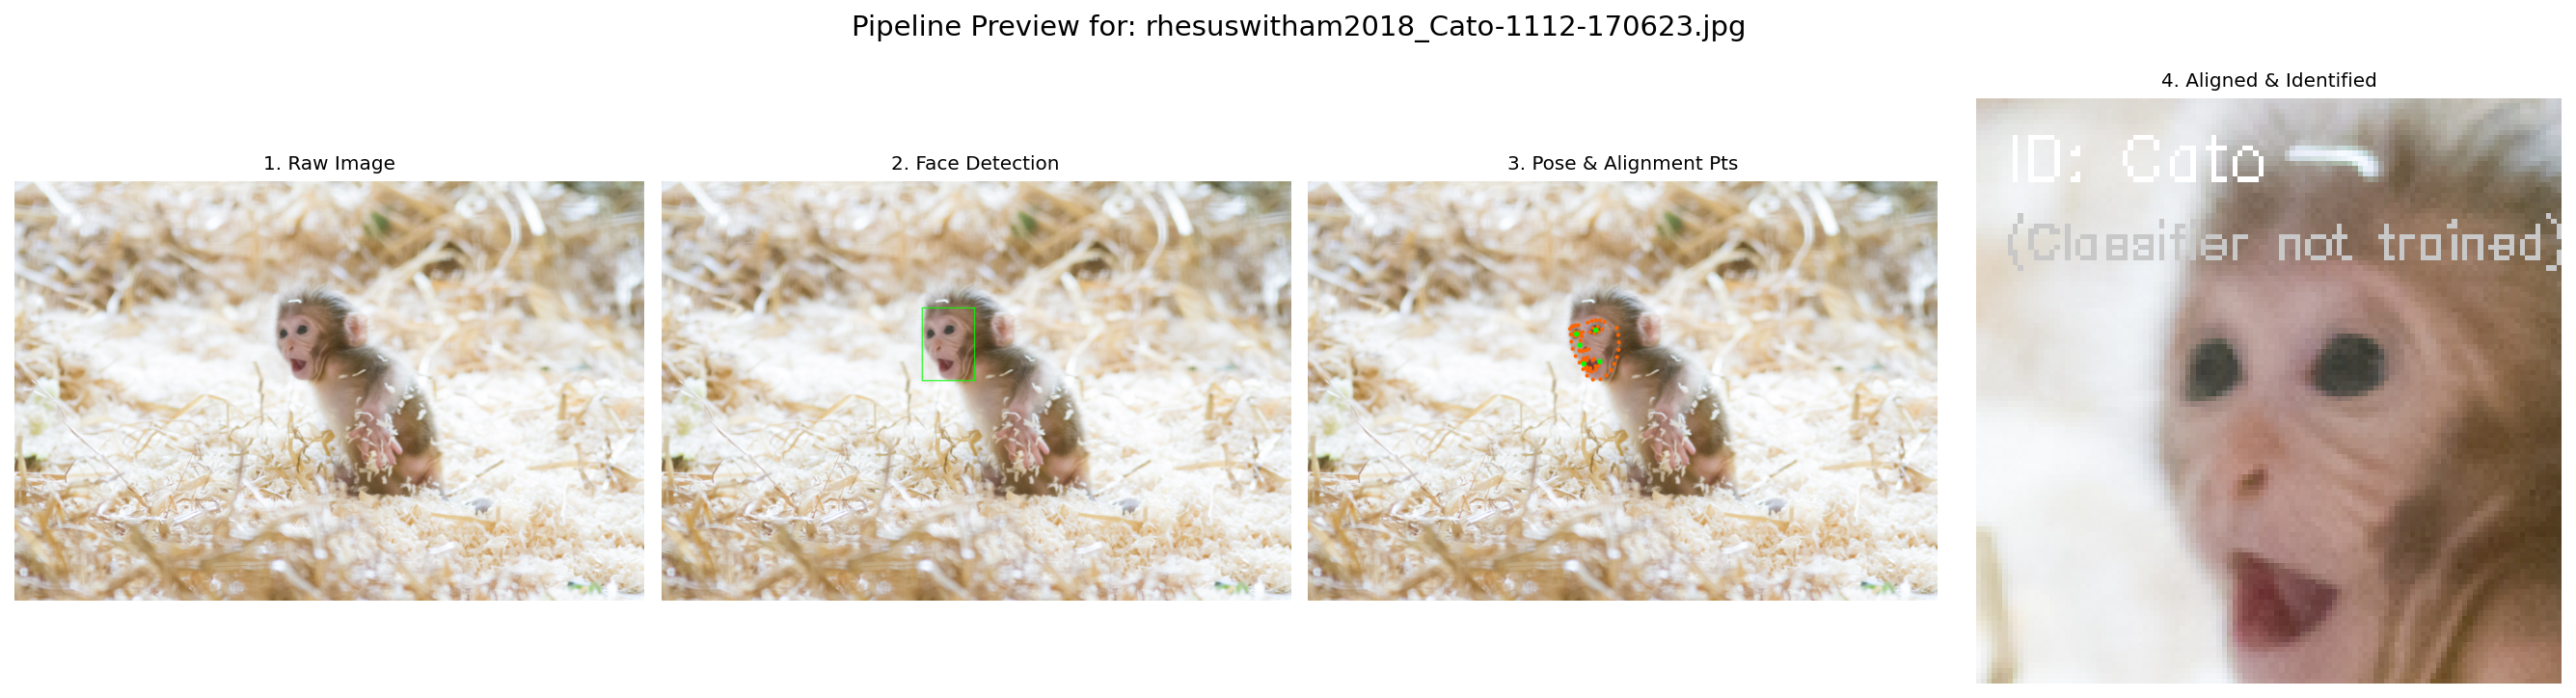

Processing image 2/3...


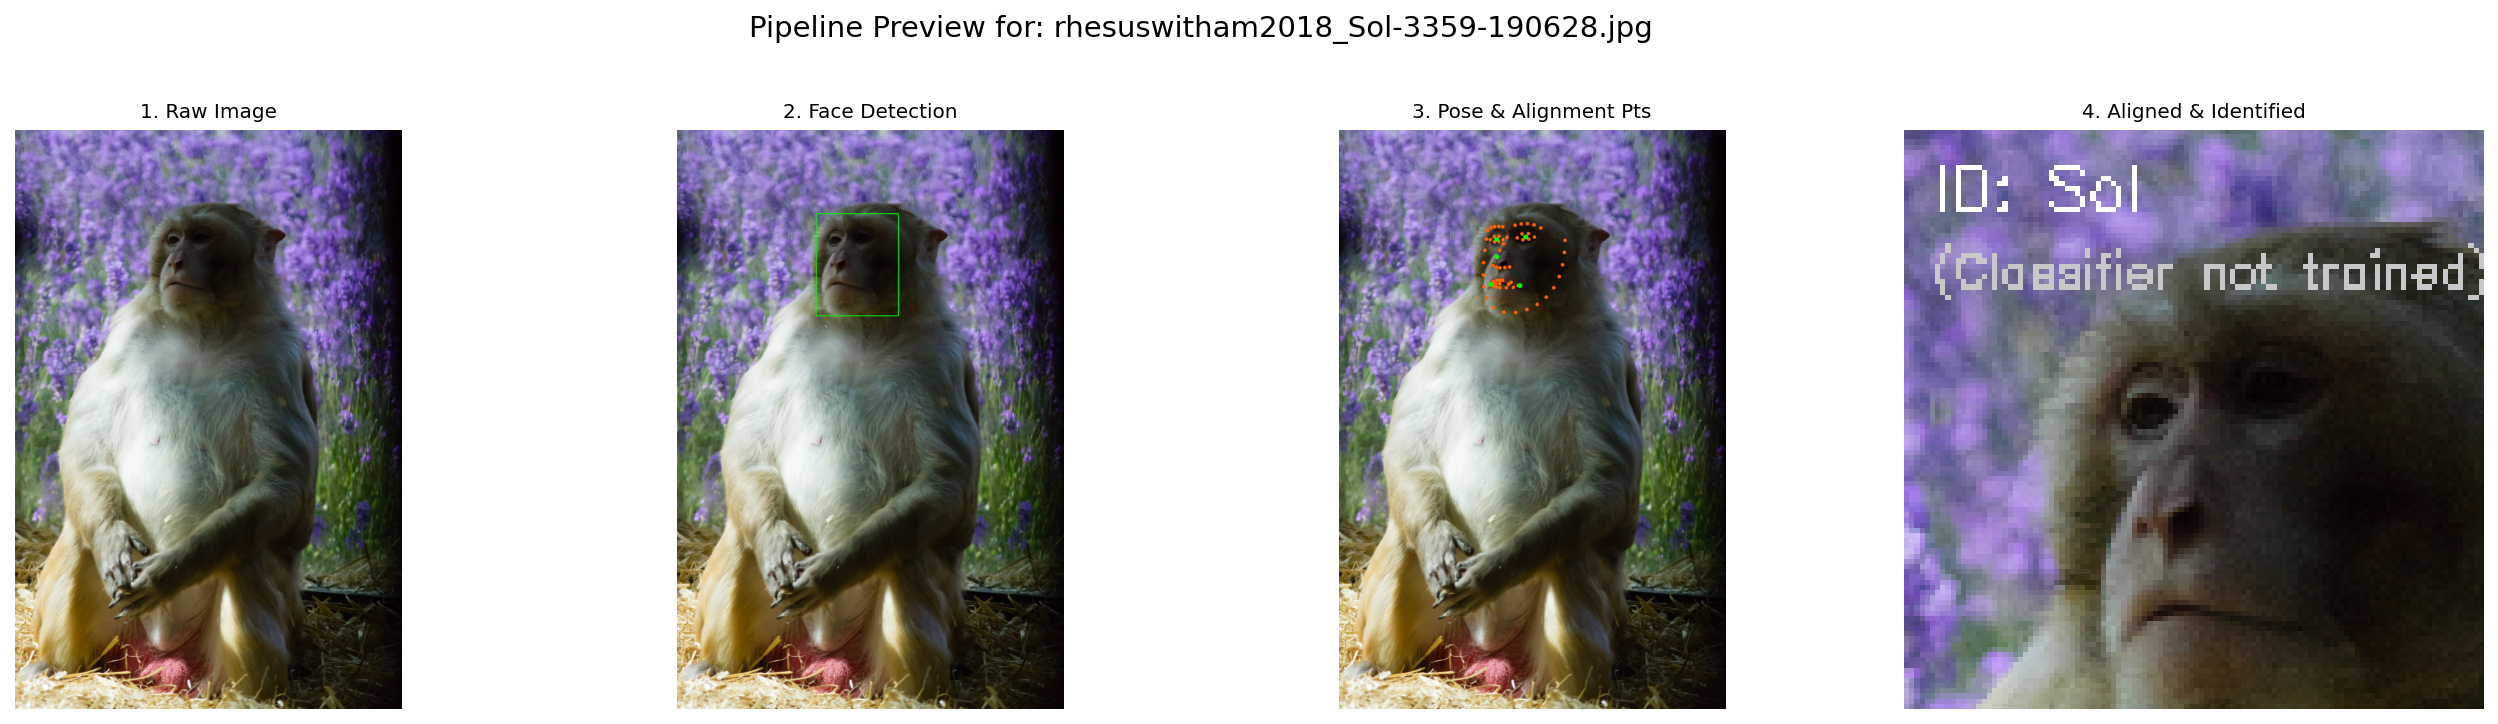

Processing image 3/3...


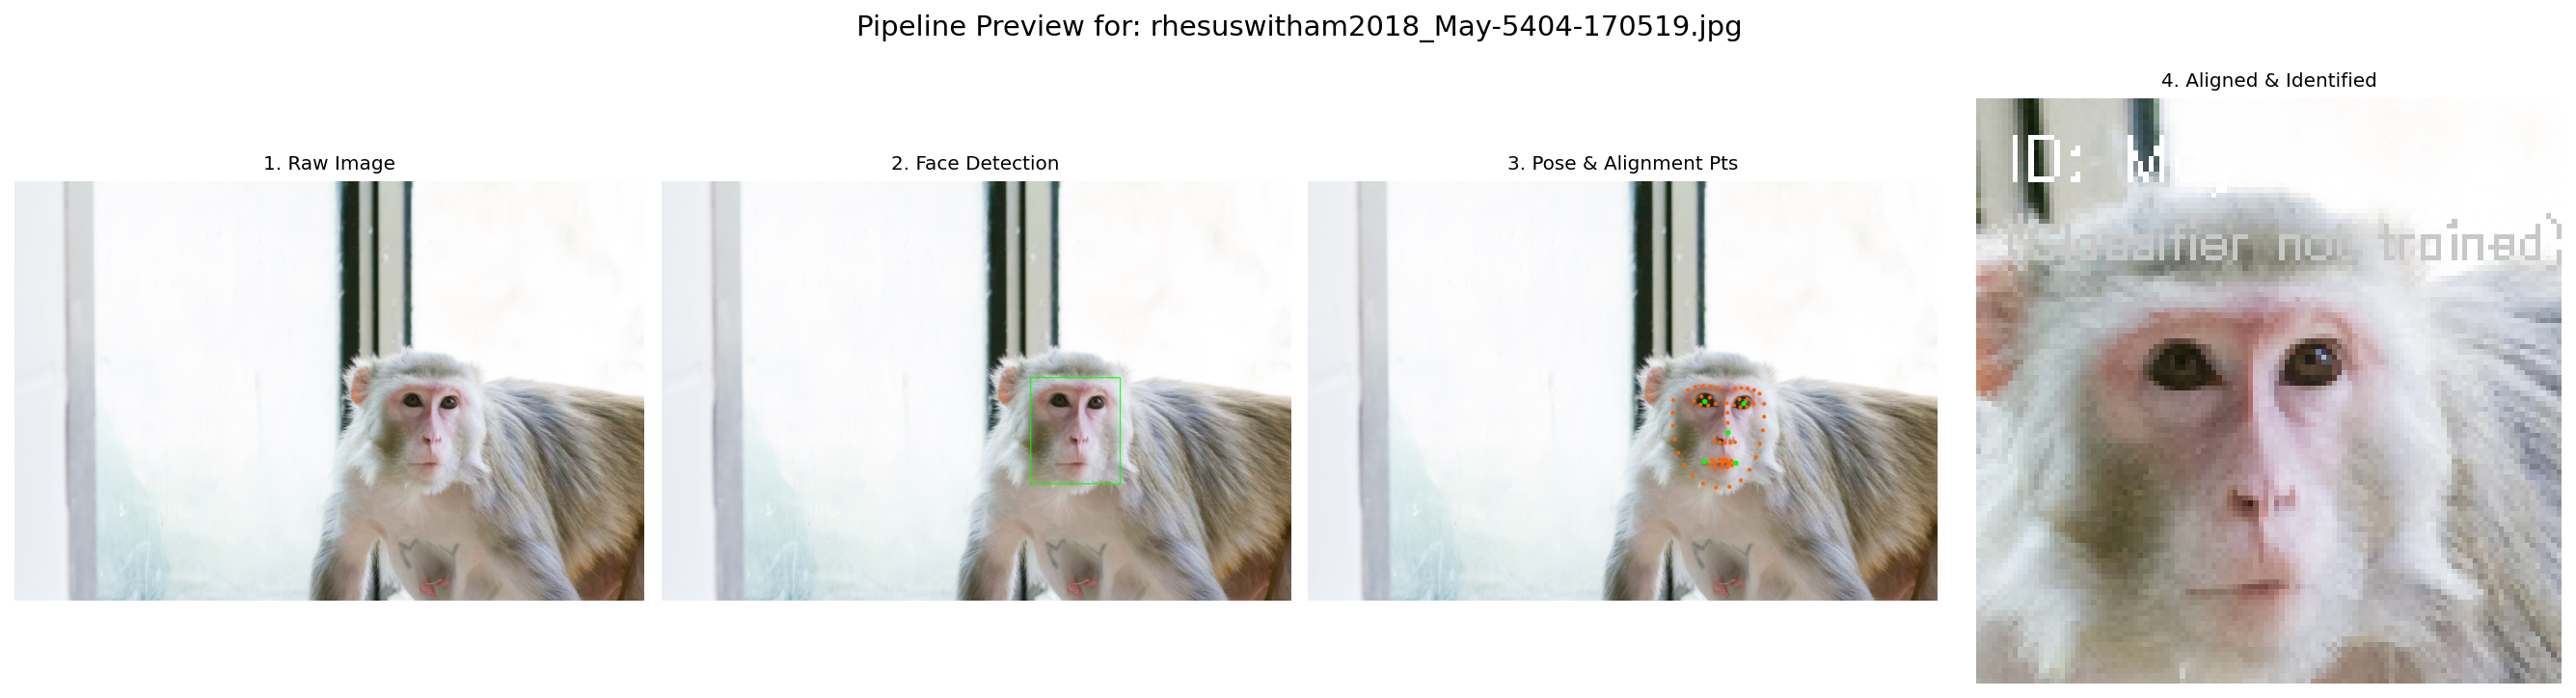

In [ ]:
#@title Preview Pipeline Steps
#@markdown Run this cell to visualize the key steps of the recognition pipeline on a few sample images. It will automatically load the necessary models and data for the preview.

#@markdown ---
#@markdown ### Preview Parameters
num_preview_images = 3 #@param {type:"slider", min:1, max:5, step:1}
#@markdown ---
import collections
import random
import cv2
import matplotlib.pyplot as plt
processing_device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# --- Helper to safely convert to numpy ---
def to_numpy(data):
    return data.cpu().numpy() if torch.is_tensor(data) else data

# --- Step 1: Ensure Models are Loaded (or Load Them Now) ---
# Use 'globals()' to check if variables exist at the notebook's global scope
if 'detector_model' not in globals() or detector_model is None:
    print("Detector model not found. Initializing now...")
    try:
        detector_model = init_detector(MMDET_CONFIG_PATH, MMDET_CHECKPOINT_PATH, device=processing_device)
        detector_model.cfg = adapt_mmdet_pipeline(detector_model.cfg)
        print("Detector model loaded successfully.")
    except Exception as e:
        print(f"FATAL: Could not load detector model. Please check paths in previous cells. Error: {e}")
        detector_model = None # Ensure it's None on failure

if 'mmpose_model' not in globals() or mmpose_model is None:
    print("MMPose model not found. Initializing now...")
    try:
        load_mmpose_model() # This function is defined in the helper cell
        print("MMPose model loaded successfully.")
    except Exception as e:
        print(f"FATAL: Could not load pose model. Error: {e}")
        mmpose_model = None # Ensure it's None on failure

# --- Step 2: Ensure Data is Loaded (or Load It Now) ---
# Use 'globals()' again to check for data lists
if 'source_paths' not in globals() or not source_paths:
    print("Image paths not yet loaded. Loading a small sample for the preview...")
    try:
        # We load with a min_samples of 1 just for the preview to ensure we get some data
        source_paths, assigned_ids, unique_ids = load_user_images_and_assign_ids(
            DATA_SOURCE_PATH,
            min_samples_per_id=1
        )
    except Exception as e:
        print(f"FATAL: Could not load data. Please check your data source path. Error: {e}")
        source_paths = [] # Ensure it's empty on failure

# --- Main Preview Logic ---
if detector_model and mmpose_model and source_paths:
    print(f"\nGenerating preview for {num_preview_images} random images...")

    # Get random indices for our preview images
    if len(source_paths) >= num_preview_images:
        preview_indices = random.sample(range(len(source_paths)), num_preview_images)
    else:
        preview_indices = range(len(source_paths))

    # Process and plot each selected image
    for i, idx in enumerate(preview_indices):
        print(f"Processing image {i+1}/{num_preview_images}...")

        im_path = source_paths[idx]
        ground_truth_id = assigned_ids[idx]

        img_bgr = cv2.imread(str(im_path))
        if img_bgr is None:
            print(f"  - Could not load image: {im_path}")
            continue

        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        fig, axes = plt.subplots(1, 4, figsize=(18, 5))
        plt.suptitle(f"Pipeline Preview for: {im_path.name}", fontsize=14)

        axes[0].imshow(img_rgb)
        axes[0].set_title("1. Raw Image")
        axes[0].axis('off')

        try:
            # Detection
            out_mmdet = inference_detector(detector_model, img_bgr)
            pred_instances = out_mmdet.pred_instances
            scores = to_numpy(pred_instances.scores)
            bboxes = to_numpy(pred_instances.bboxes)
            best_bbox = bboxes[scores.argmax()]

            img_with_bbox = img_rgb.copy()
            x1, y1, x2, y2 = map(int, best_bbox)
            cv2.rectangle(img_with_bbox, (x1, y1), (x2, y2), (0, 255, 0), 2)
            axes[1].imshow(img_with_bbox)
            axes[1].set_title("2. Face Detection")
            axes[1].axis('off')

            # Pose Estimation
            pose_results = inference_topdown(mmpose_model, img_bgr, [best_bbox], bbox_format='xyxy')
            landmarks_68 = to_numpy(pose_results[0].pred_instances.keypoints[0])
            source_5pts = get_5_source_landmarks_from_68(landmarks_68)

            img_with_pose = img_rgb.copy()
            for x, y in landmarks_68:
                cv2.circle(img_with_pose, (int(x), int(y)), 6, (255, 100, 0), -1)
            for x, y in source_5pts:
                cv2.circle(img_with_pose, (int(x), int(y)), 8, (0, 255, 0), -1)
            axes[2].imshow(img_with_pose)
            axes[2].set_title("3. Pose & Alignment Pts")
            axes[2].axis('off')

            # Alignment and Identification
            aligned_bgr = align_face_5pts(img_bgr, source_5pts)
            aligned_rgb = cv2.cvtColor(aligned_bgr, cv2.COLOR_BGR2RGB)

            text_to_display = f"ID: {ground_truth_id}\n(Classifier not trained)"
            # Check if classifier has been trained
            if 'best_clf' in globals() and best_clf is not None:
                embedding = get_embedding(aligned_bgr)
                pred_idx = best_clf.predict([embedding])
                pred_id = le.inverse_transform(pred_idx)[0]
                text_to_display = f"Predicted ID: {pred_id}"

            cv2.putText(aligned_rgb, text_to_display.split('\n')[0], (5, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
            if '\n' in text_to_display:
                cv2.putText(aligned_rgb, text_to_display.split('\n')[1], (5, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (200, 200, 200), 1)

            axes[3].imshow(aligned_rgb)
            axes[3].set_title("4. Aligned & Identified")
            axes[3].axis('off')

        except Exception as e:
            error_text = f"Preview failed:\n{e}"
            print(f"  - {error_text}")
            axes[1].text(0.5, 0.5, error_text, ha='center', va='center', wrap=True, color='red')
            axes[1].axis('off'); axes[2].axis('off'); axes[3].axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

else:
    print("\n❌ Preview could not run. Please check the error messages above and ensure all previous setup cells have run successfully.")

In [ ]:
#@title Step 4: Prepare Data and Extract Embeddings (takes ~25 min to run on ~4,000 images)

#@markdown This cell runs the time-consuming part of the pipeline: detecting faces, aligning them, and extracting a unique feature vector (embedding) for each.

#@markdown It creates a checkpoint file named `embeddings.npz`. If this file already exists, the cell will skip processing and you can proceed to Step 5.

#@markdown Set the minimum number of images required for an individual to be included in the analysis.
min_samples_per_id = 4 #@param {type:"slider", min:1, max:20, step:1}


import os

EMBEDDINGS_FILE = "embeddings.npz"

# --- Smart Checkpoint Logic ---
if os.path.exists(EMBEDDINGS_FILE):
    print(f"✅ Found existing embeddings file: '{EMBEDDINGS_FILE}'")
    print("⏩ You can now proceed to 'Step 5: Train Classifier'.")
    print("\n" + "="*60)
    print("❗ IMPORTANT: If you changed your source data, delete the file")
    print(f"   by right-clicking '{EMBEDDINGS_FILE}' in the file browser on the left")
    print("   and then rerun this cell.")
    print("="*60)
else:
    print(f"No checkpoint file found. Running the full data preparation pipeline...\n")

    # 1. Initialize Models (if not already loaded)
    print("--- 1. Initializing Models ---")
    processing_device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    if 'detector_model' not in globals() or detector_model is None:
        detector_model = init_detector(MMDET_CONFIG_PATH, MMDET_CHECKPOINT_PATH, device=processing_device)
        detector_model.cfg = adapt_mmdet_pipeline(detector_model.cfg)
    if 'mmpose_model' not in globals() or mmpose_model is None:
        load_mmpose_model()
    print("-" * 30)

    # 2. Prepare image paths and IDs (using a temporary min_samples to load all valid data)
    print("\n--- 2. Preparing Dataset ---")
    source_paths, assigned_ids, unique_ids = load_user_images_and_assign_ids(
        DATA_SOURCE_PATH, min_samples_per_id=min_samples_per_id # Load all valid individuals initially
    )

    # 3. Detect, Align, and Crop Faces
    print("\n--- 3. Detecting, Aligning, and Cropping Faces ---")
    output_base_dir = Path("primate_recognition_demo")
    crop_dir = detect_and_crop_faces(detector_model, source_paths, assigned_ids, output_base_dir)

    # 4. Extract Embeddings
    print("\n--- 4. Extracting Face Embeddings ---")
    X_embed, y_labels, img_paths = extract_embeddings_direct(crop_dir)

    if X_embed is not None:
        print(f"\n✅ Successfully created and saved '{EMBEDDINGS_FILE}'. You can now run Step 5.")
    else:
        print("\n❌ ERROR: Embedding extraction failed. Cannot proceed.")

No checkpoint file found. Running the full data preparation pipeline...

--- 1. Initializing Models ---
------------------------------

--- 2. Preparing Dataset ---
Scanning for images in /content/drive/MyDrive/PrimateFace/demo-input-videos/face_rec_witham...
Found 3870 images across 72 initial unique IDs.
Found 57 IDs with at least 4 samples each.

---> Final dataset for pipeline: 3841 images from 57 individuals.
First 5 unique IDs being used: ['Arlene', 'Ash', 'August', 'Badonde', 'Beowulf']

--- 3. Detecting, Aligning, and Cropping Faces ---
Detecting, aligning, and cropping faces...


Detecting & Aligning:   0%|          | 0/3841 [00:00<?, ?it/s]

In [ ]:
#@title Step 5: Train Classifier and Evaluate Performance
#@markdown This cell loads the `embeddings.npz` file, trains the classifiers using **Grid Search** to find the best parameters, and generates all performance plots.
#@markdown
#@markdown You can adjust the `min_samples_per_id` and rerun this cell quickly without reprocessing all the images.
#@markdown ---
#@markdown ### Curation and Training Parameters
#@markdown Tick the box to apply brightness/contrast augmentation to the training images.
apply_augmentation = False #@param {type:"boolean"}
FIGURES_OUTPUT_DIR = "figures_recognition_demo"
#@markdown ---

import os
import collections

EMBEDDINGS_FILE = "embeddings.npz"

# --- Load data from checkpoint ---
if not os.path.exists(EMBEDDINGS_FILE):
    print("❌ ERROR: Embeddings file not found!")
    print("Please run 'Step 4: Prepare Data and Extract Embeddings' first.")
else:
    print(f"Loading data from {EMBEDDINGS_FILE}...")
    data = np.load(EMBEDDINGS_FILE, allow_pickle=True)
    X_embed_all = data['X']
    y_labels_all = data['y']
    img_paths_all = data['paths']

    # --- Filter data based on the current min_samples setting ---
    print(f"Filtering loaded data for individuals with at least {min_samples_per_id} samples...")
    id_counts = collections.Counter(y_labels_all)
    valid_ids = {id_ for id_, count in id_counts.items() if count >= min_samples_per_id}

    mask = [label in valid_ids for label in y_labels_all]
    X_filtered = X_embed_all[mask]
    y_filtered = y_labels_all[mask]
    paths_filtered = img_paths_all[mask]

    print(f"Proceeding to train on {len(X_filtered)} samples from {len(valid_ids)} individuals.")

    # --- Train Classifier ---
    if len(X_filtered) > 0 and len(valid_ids) >= 2:
        (best_clf, le, final_acc, y_train_shuffled,
         X_te, y_te, y_pred, y_prob) = train_classifier(X_filtered, y_filtered, paths_filtered, augment=apply_augmentation)

        # --- Post-Training Analysis ---
        if best_clf is not None:
            # Shuffle Control
            print("\n--- Running Label Shuffle Control ---")
            # We need the training embeddings for the shuffle control
            X_tr_emb, _, _, _ = train_test_split(X_filtered, y_filtered, test_size=0.3, stratify=y_filtered, random_state=0)
            shuffled_clf = SVC(kernel='rbf', probability=True, random_state=1)
            shuffled_clf.fit(X_tr_emb, y_train_shuffled)
            shuffled_acc = shuffled_clf.score(X_te, y_te)
            print(f"Accuracy of SVM on shuffled labels: {shuffled_acc:.4f}")

            # Figure Generation
            print("\n--- Generating Summary Figures ---")
            chance = 1.0 / len(le.classes_)
            generate_shuffle_control_summary_plot(final_acc, shuffled_acc, chance, FIGURES_OUTPUT_DIR)
            generate_figures(X_filtered, y_filtered, list(le.classes_), X_te, le.inverse_transform(y_te),
                             le.inverse_transform(y_pred), y_prob, final_acc, le, output_dir=FIGURES_OUTPUT_DIR)

            print("\n\n--- Analysis Finished ---")
        else:
            print("\n--- Classifier training failed. No results to show. ---")
    else:
        print("\n--- Training skipped. Not enough data or classes after filtering. ---")
        print(f"Please try a lower 'min_samples_per_id' value.")

Loading data from embeddings.npz...
Filtering loaded data for individuals with at least 20 samples...
Proceeding to train on 3685 samples from 38 individuals.
Training ID classifiers with GridSearchCV...

Running GridSearchCV for SVM...
Fitting 3 folds for each of 15 candidates, totalling 45 fits


KeyboardInterrupt: 

✅ Found existing embeddings file: 'embeddings.npz'
⏩ Skipping detection and embedding steps and jumping straight to training.

❗ IMPORTANT: You are using a pre-existing checkpoint file.
   If you have changed your dataset or the `min_samples_per_id`
   setting, you MUST delete this file first! To do so:
   1. Click the 'Files' icon on the left sidebar.
   2. Right-click on 'embeddings.npz' and choose 'Delete'.
   3. Rerun this cell.

Successfully loaded 3888 embeddings.

--- 5. Filtering Data and Training Classifier ---
Filtered embeddings down to 3832 samples from 55 individuals.
Training ID classifiers...
Training SVM...
SVM Test Accuracy: 0.0757
Training MLP...
MLP Test Accuracy: 0.8374
Best classifier is MLP.

--- 6. Running Label Shuffle Control ---
Accuracy on shuffled labels: 0.0739

--- 7. Generating Summary Figures ---
Figure saved to figures_recognition_demo/summary_accuracy_plot.pdf and .png


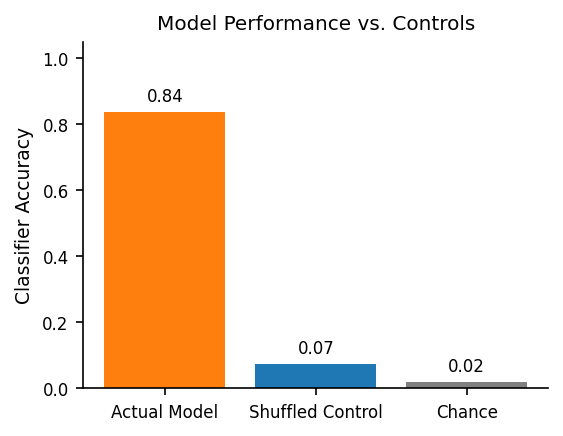

Generating t-SNE plot...
Figure saved to figures_recognition_demo/tsne_embeddings.pdf and .png


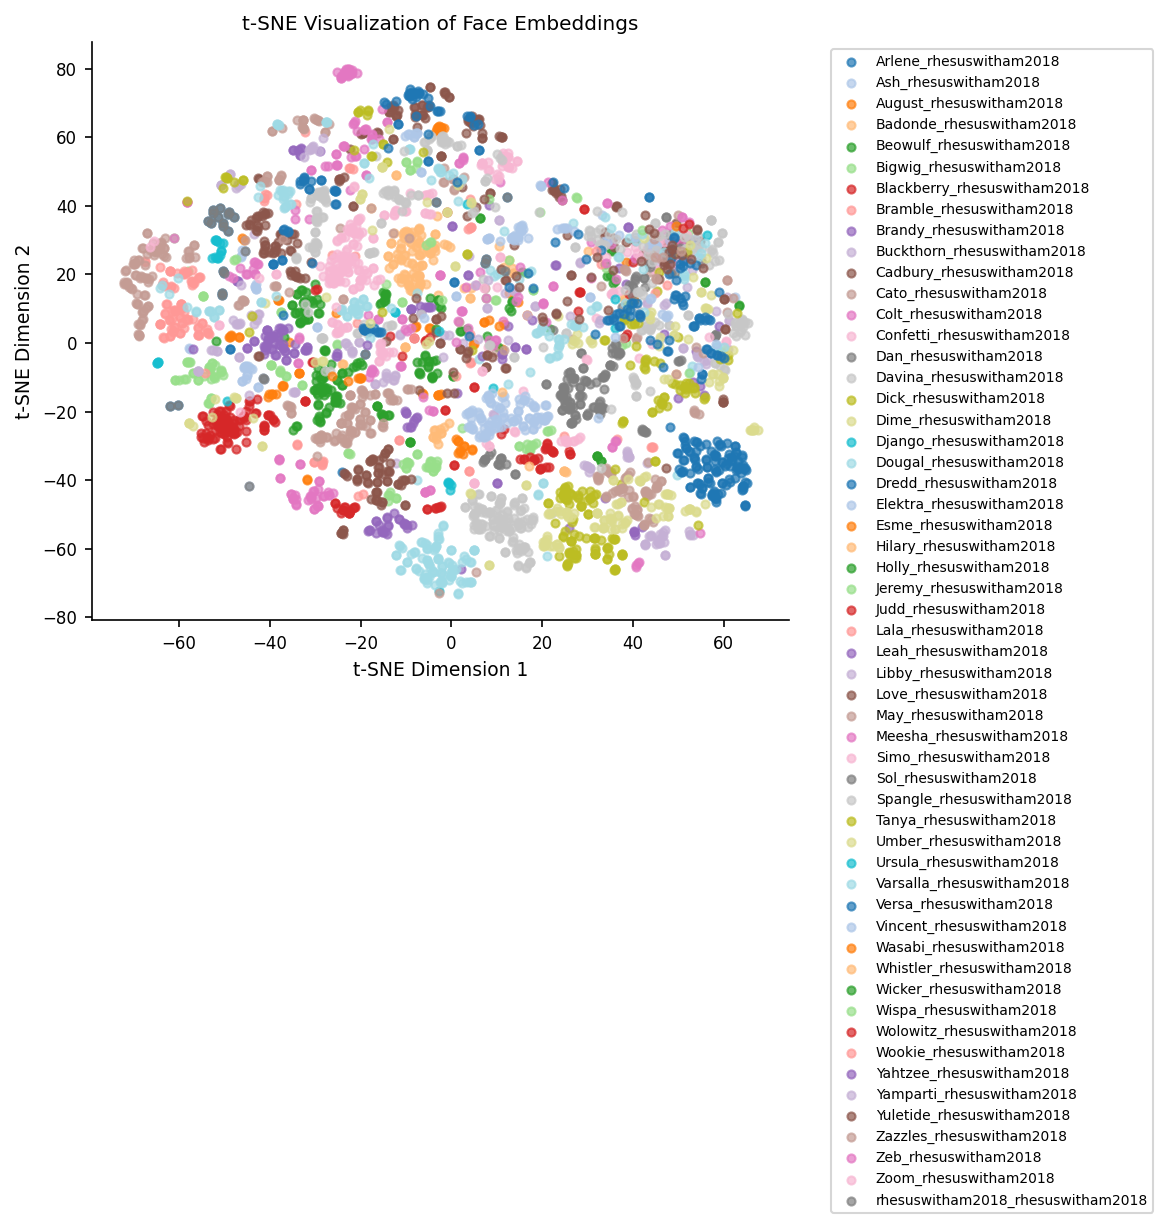

Generating confusion matrix...
Figure saved to figures_recognition_demo/confusion_matrix.pdf and .png


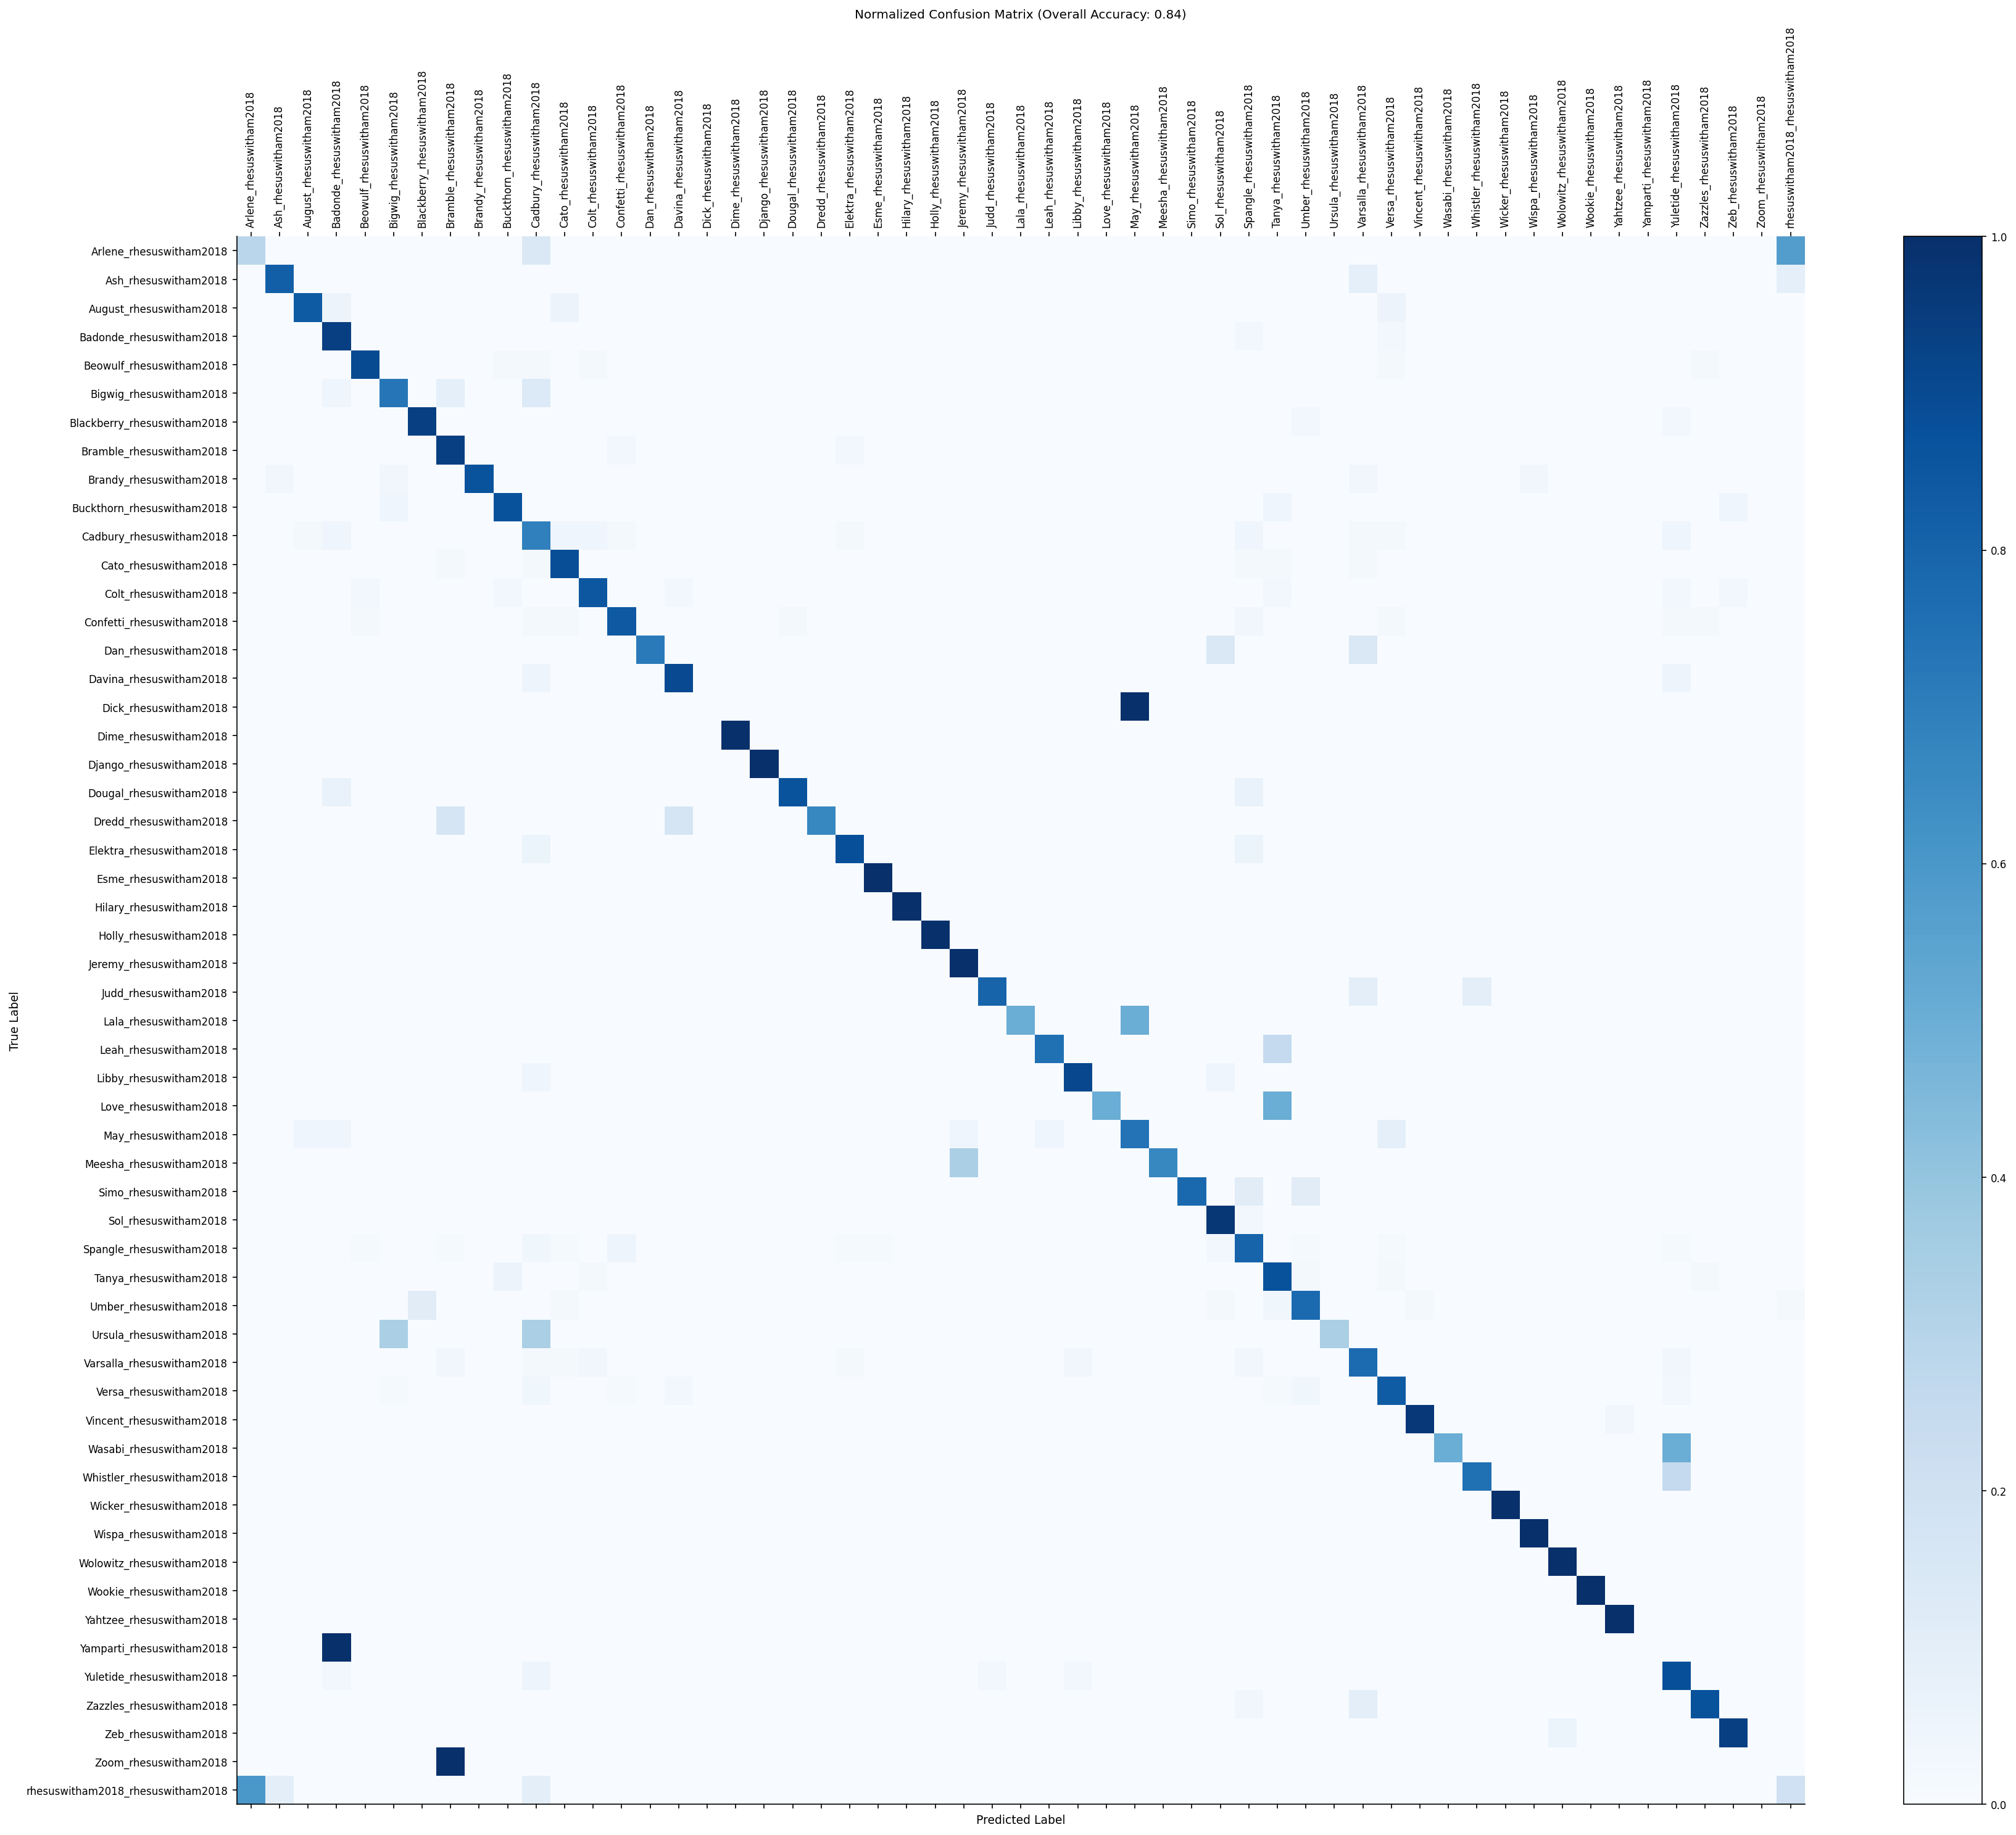



--- Pipeline Finished ---


In [ ]:
#@title Run Full Pipeline (Detection, Embedding, Classification)
#@markdown **On a T4 GPU, this should take ~30 min.**

#@markdown ---
#@markdown ### Analysis Parameters
#@markdown Tick the box below to apply brightness/contrast augmentation to the training images. This can improve classifier robustness.
apply_augmentation = False #@param {type:"boolean"}
FIGURES_OUTPUT_DIR = "figures_recognition_demo"
#@markdown ---
#@markdown ### Dataset Curation
#@markdown Set the minimum number of images required for an individual to be included in the analysis.
min_samples_per_id = 5 #@param {type:"slider", min:1, max:20, step:1}
#@markdown ---

import os

processing_device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
EMBEDDINGS_FILE = "embeddings.npz"

# Initialize variables to hold our data
X_embed, y_labels, img_paths = None, None, None

# --- Smart Checkpoint Logic ---
if os.path.exists(EMBEDDINGS_FILE):
    print(f"✅ Found existing embeddings file: '{EMBEDDINGS_FILE}'")
    print("⏩ Skipping detection and embedding steps and jumping straight to training.")

    # --- CRITICAL WARNING FOR THE USER ---
    print("\n" + "="*60)
    print("❗ IMPORTANT: You are using a pre-existing checkpoint file.")
    print("   If you have changed your dataset or the `min_samples_per_id`")
    print("   setting, you MUST delete this file first! To do so:")
    print("   1. Click the 'Files' icon on the left sidebar.")
    print(f"   2. Right-click on '{EMBEDDINGS_FILE}' and choose 'Delete'.")
    print("   3. Rerun this cell.")
    print("="*60 + "\n")

    try:
        data = np.load(EMBEDDINGS_FILE, allow_pickle=True)
        X_embed = data['X']
        y_labels = data['y']
        img_paths = data['paths']
        print(f"Successfully loaded {X_embed.shape[0]} embeddings.")
    except Exception as e:
        print(f"Error loading {EMBEDDINGS_FILE}: {e}. Please delete it and rerun.")
        X_embed = None # Ensure it's None on failure

else:
    print(f"No checkpoint file found. Running the full pipeline from scratch...\n")

    # --- Full pipeline logic (only runs if the .npz file doesn't exist) ---
    # 1. Initialize Models (if not already loaded)
    print("--- 1. Initializing Models ---")
    if 'detector_model' not in globals() or detector_model is None:
        detector_model = init_detector(MMDET_CONFIG_PATH, MMDET_CHECKPOINT_PATH, device=processing_device)
        detector_model.cfg = adapt_mmdet_pipeline(detector_model.cfg)
    if 'mmpose_model' not in globals() or mmpose_model is None:
        load_mmpose_model()
    print("-" * 30)

    # 2. Prepare image paths and IDs
    print("\n--- 2. Preparing Dataset ---")
    source_paths, assigned_ids, unique_ids = load_user_images_and_assign_ids(
        DATA_SOURCE_PATH, min_samples_per_id=min_samples_per_id
    )

    # 3. Detect, Align, and Crop Faces
    print("\n--- 3. Detecting, Aligning, and Cropping Faces ---")
    output_base_dir = Path("primate_recognition_demo")
    crop_dir = detect_and_crop_faces(detector_model, source_paths, assigned_ids, output_base_dir)

    # 4. Extract Embeddings
    print("\n--- 4. Extracting Face Embeddings ---")
    X_embed, y_labels, img_paths = extract_embeddings_direct(crop_dir)

# --- Classifier Training (runs in both cases) ---
if X_embed is not None and len(X_embed) > 0:
    # Now, filter the loaded or generated data based on the current min_samples setting
    print("\n--- 5. Filtering Data and Training Classifier ---")

    # This is a crucial safety step: we re-filter the loaded data
    id_counts = collections.Counter(y_labels)
    valid_ids = {id_ for id_, count in id_counts.items() if count >= min_samples_per_id}

    mask = [label in valid_ids for label in y_labels]
    X_filtered = X_embed[mask]
    y_filtered = np.array(y_labels)[mask]
    paths_filtered = np.array(img_paths)[mask]

    print(f"Filtered embeddings down to {len(X_filtered)} samples from {len(valid_ids)} individuals.")

    if len(X_filtered) > 0:
        (best_clf, le, final_acc, y_train_shuffled,
         X_te, y_te, y_pred, y_prob) = train_classifier(X_filtered, y_filtered, paths_filtered, augment=apply_augmentation)

        # ... (Rest of the plotting and analysis code is the same) ...
        print("\n--- 6. Running Label Shuffle Control ---")
        X_train_len = len(y_train_shuffled)
        X_train_filtered = X_filtered[[i for i, label in enumerate(y_filtered) if np.any(LabelEncoder().fit_transform([label]) == y_train_shuffled)]] # a bit complex but finds original indices

        # A simpler way to get the training embeddings before shuffle
        X_tr_emb, _, _, _ = train_test_split(X_filtered, y_filtered, test_size=0.3, stratify=y_filtered, random_state=0)

        shuffled_clf = SVC(kernel='rbf', probability=True, C=10, gamma=0.1, random_state=1)
        shuffled_clf.fit(X_tr_emb, y_train_shuffled)
        shuffled_acc = shuffled_clf.score(X_te, y_te)
        print(f"Accuracy on shuffled labels: {shuffled_acc:.4f}")

        print("\n--- 7. Generating Summary Figures ---")
        chance = 1.0 / len(le.classes_) if len(le.classes_) > 0 else 0
        generate_shuffle_control_summary_plot(final_acc, shuffled_acc, chance, FIGURES_OUTPUT_DIR)
        generate_figures(X_filtered, y_filtered, list(le.classes_), X_te, le.inverse_transform(y_te), le.inverse_transform(y_pred), y_prob, final_acc, le, output_dir=FIGURES_OUTPUT_DIR)
    else:
        print("No data left after filtering with the new `min_samples_per_id` setting. Please adjust and rerun.")
else:
    print("\nPipeline stopped because no embeddings were loaded or extracted.")

print("\n\n--- Pipeline Finished ---")

## **5. Review Results**

The figures below summarize the performance of the face recognition pipeline on your dataset. They have been saved to the `figures_recognition_demo` directory.

*   **t-SNE Embeddings Plot**: This plot visualizes the high-dimensional (512-D) face embeddings in a 2D space. Ideally, embeddings from the same individual (same color) should cluster together, while embeddings from different individuals should be separated. This shows how well the recognition model distinguishes between faces.

*   **Confusion Matrix**: This matrix shows the classifier's performance. The diagonal represents correct identifications. Off-diagonal cells show misidentifications (e.g., if the model confuses ID_01 with ID_02). Values are normalized, so 1.0 on the diagonal is perfect accuracy for that ID.

*   **Image Retrieval Grid**: This shows a few random "query" images from the test set. For each query, the system finds the top 3 most similar-looking faces from the entire dataset based on their embeddings. This demonstrates the power of embeddings for similarity search.

*   **One-vs-Rest (OvR) ROC Curves**: This plot evaluates the classifier's ability to distinguish each individual against all others. An Area Under the Curve (AUC) of 1.0 is perfect, while 0.5 is equivalent to random chance. The micro- and macro-averages provide an overall sense of classifier performance across all individuals.

*   **Shuffle Control Summary**: This bar chart is a critical sanity check. It compares the accuracy of the model trained on real labels to one trained on shuffled (randomized) labels. The "Actual Model" should perform significantly better than the "Shuffled" models and "Chance" level, confirming that it has learned meaningful, identity-specific features.


--- Displaying: figures_recognition_demo/confusion_matrix.png ---


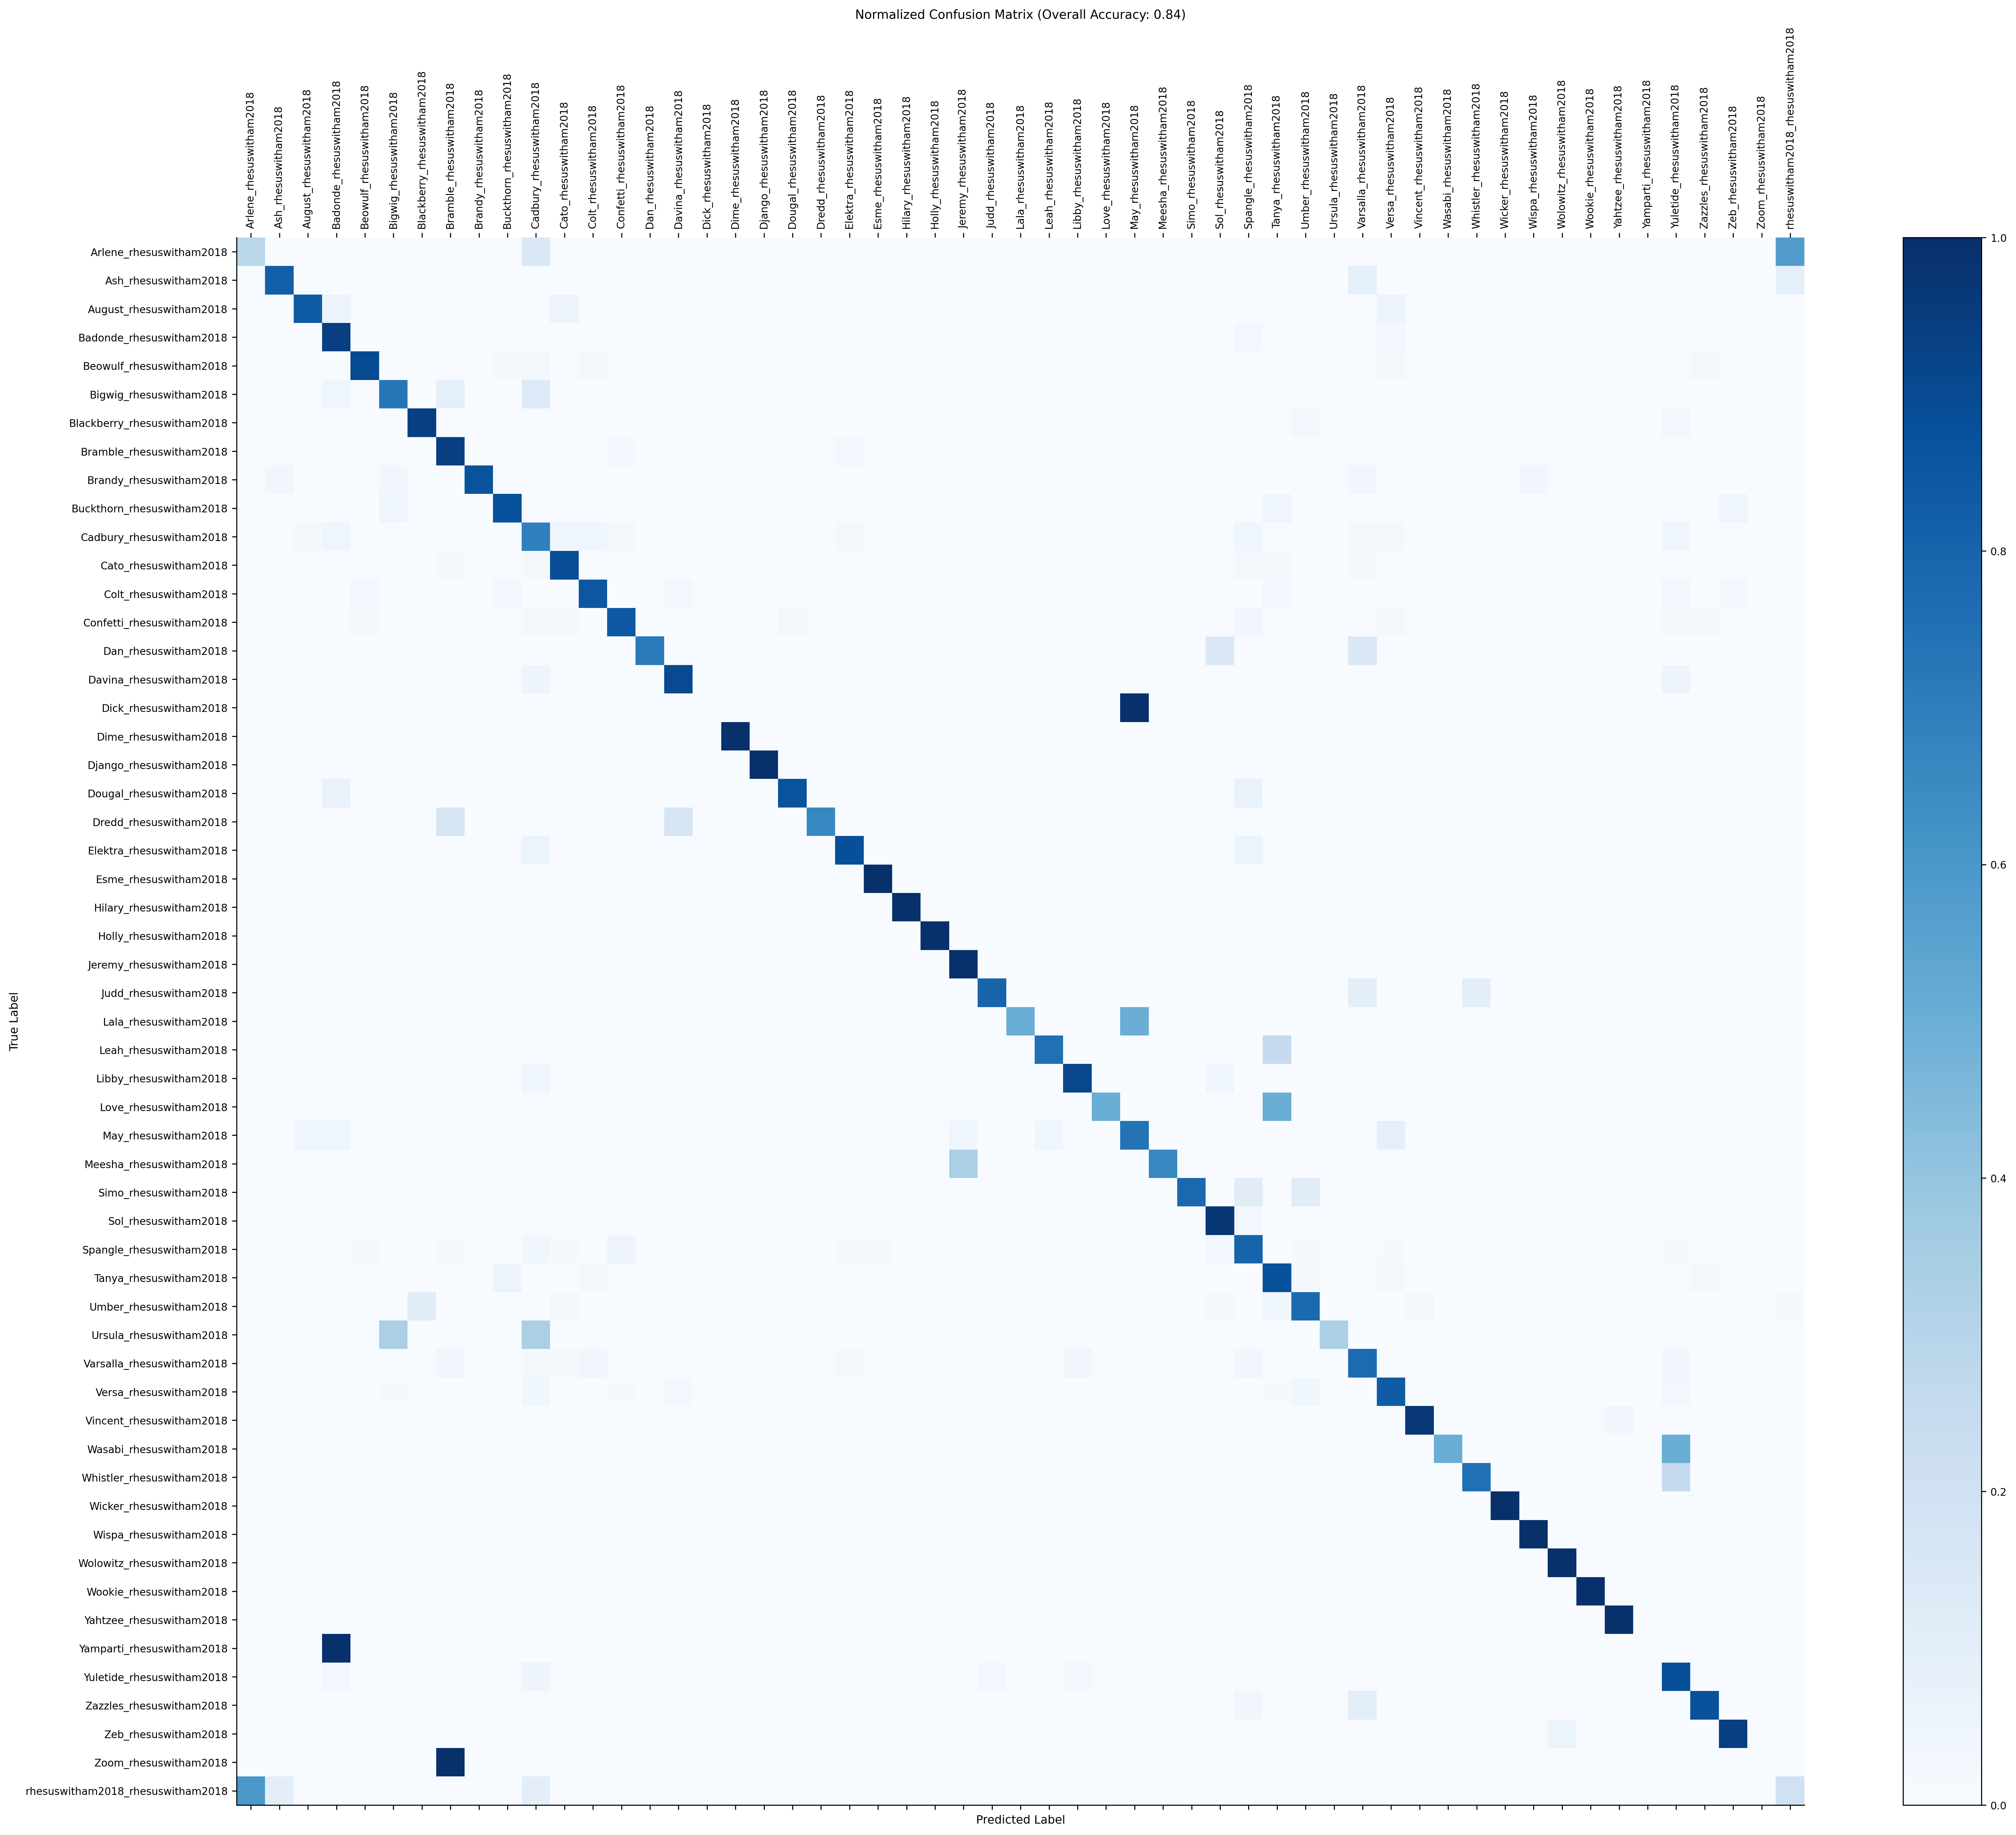


--- Displaying: figures_recognition_demo/summary_accuracy_plot.png ---


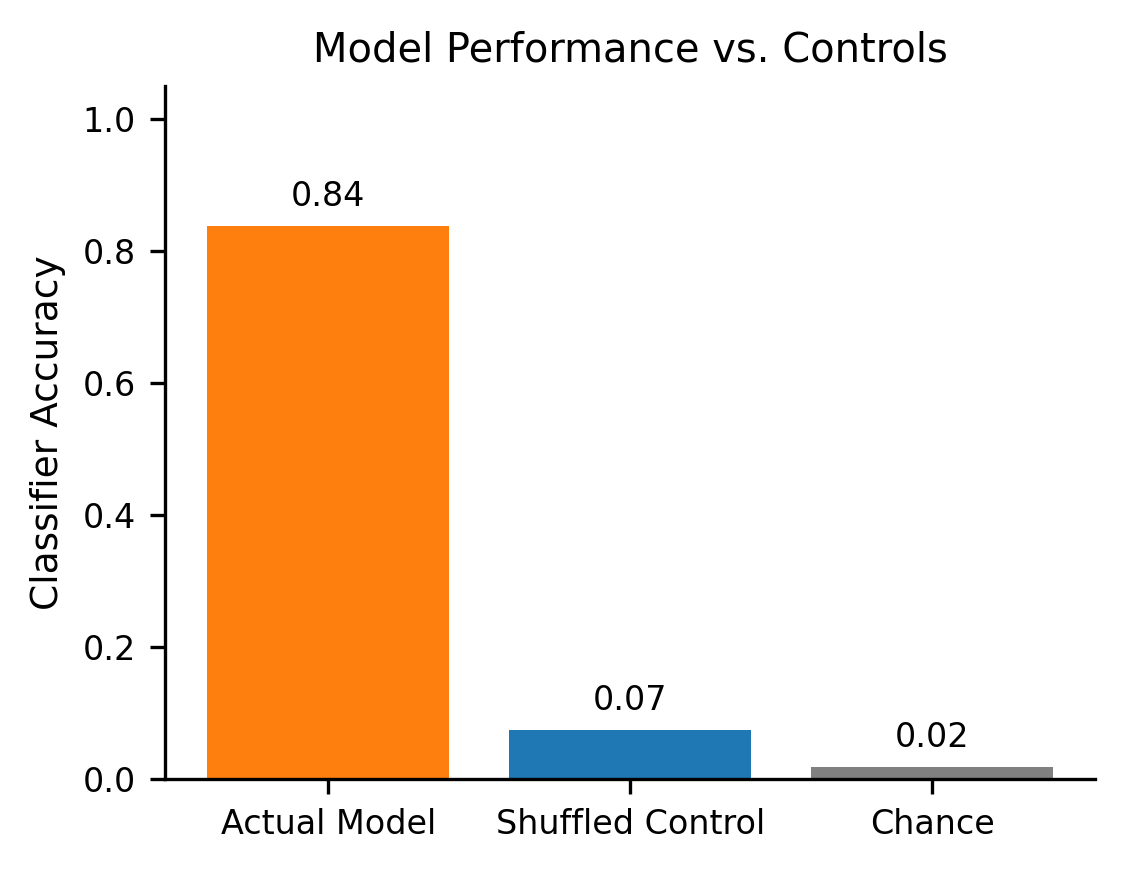


--- Displaying: figures_recognition_demo/tsne_embeddings.png ---


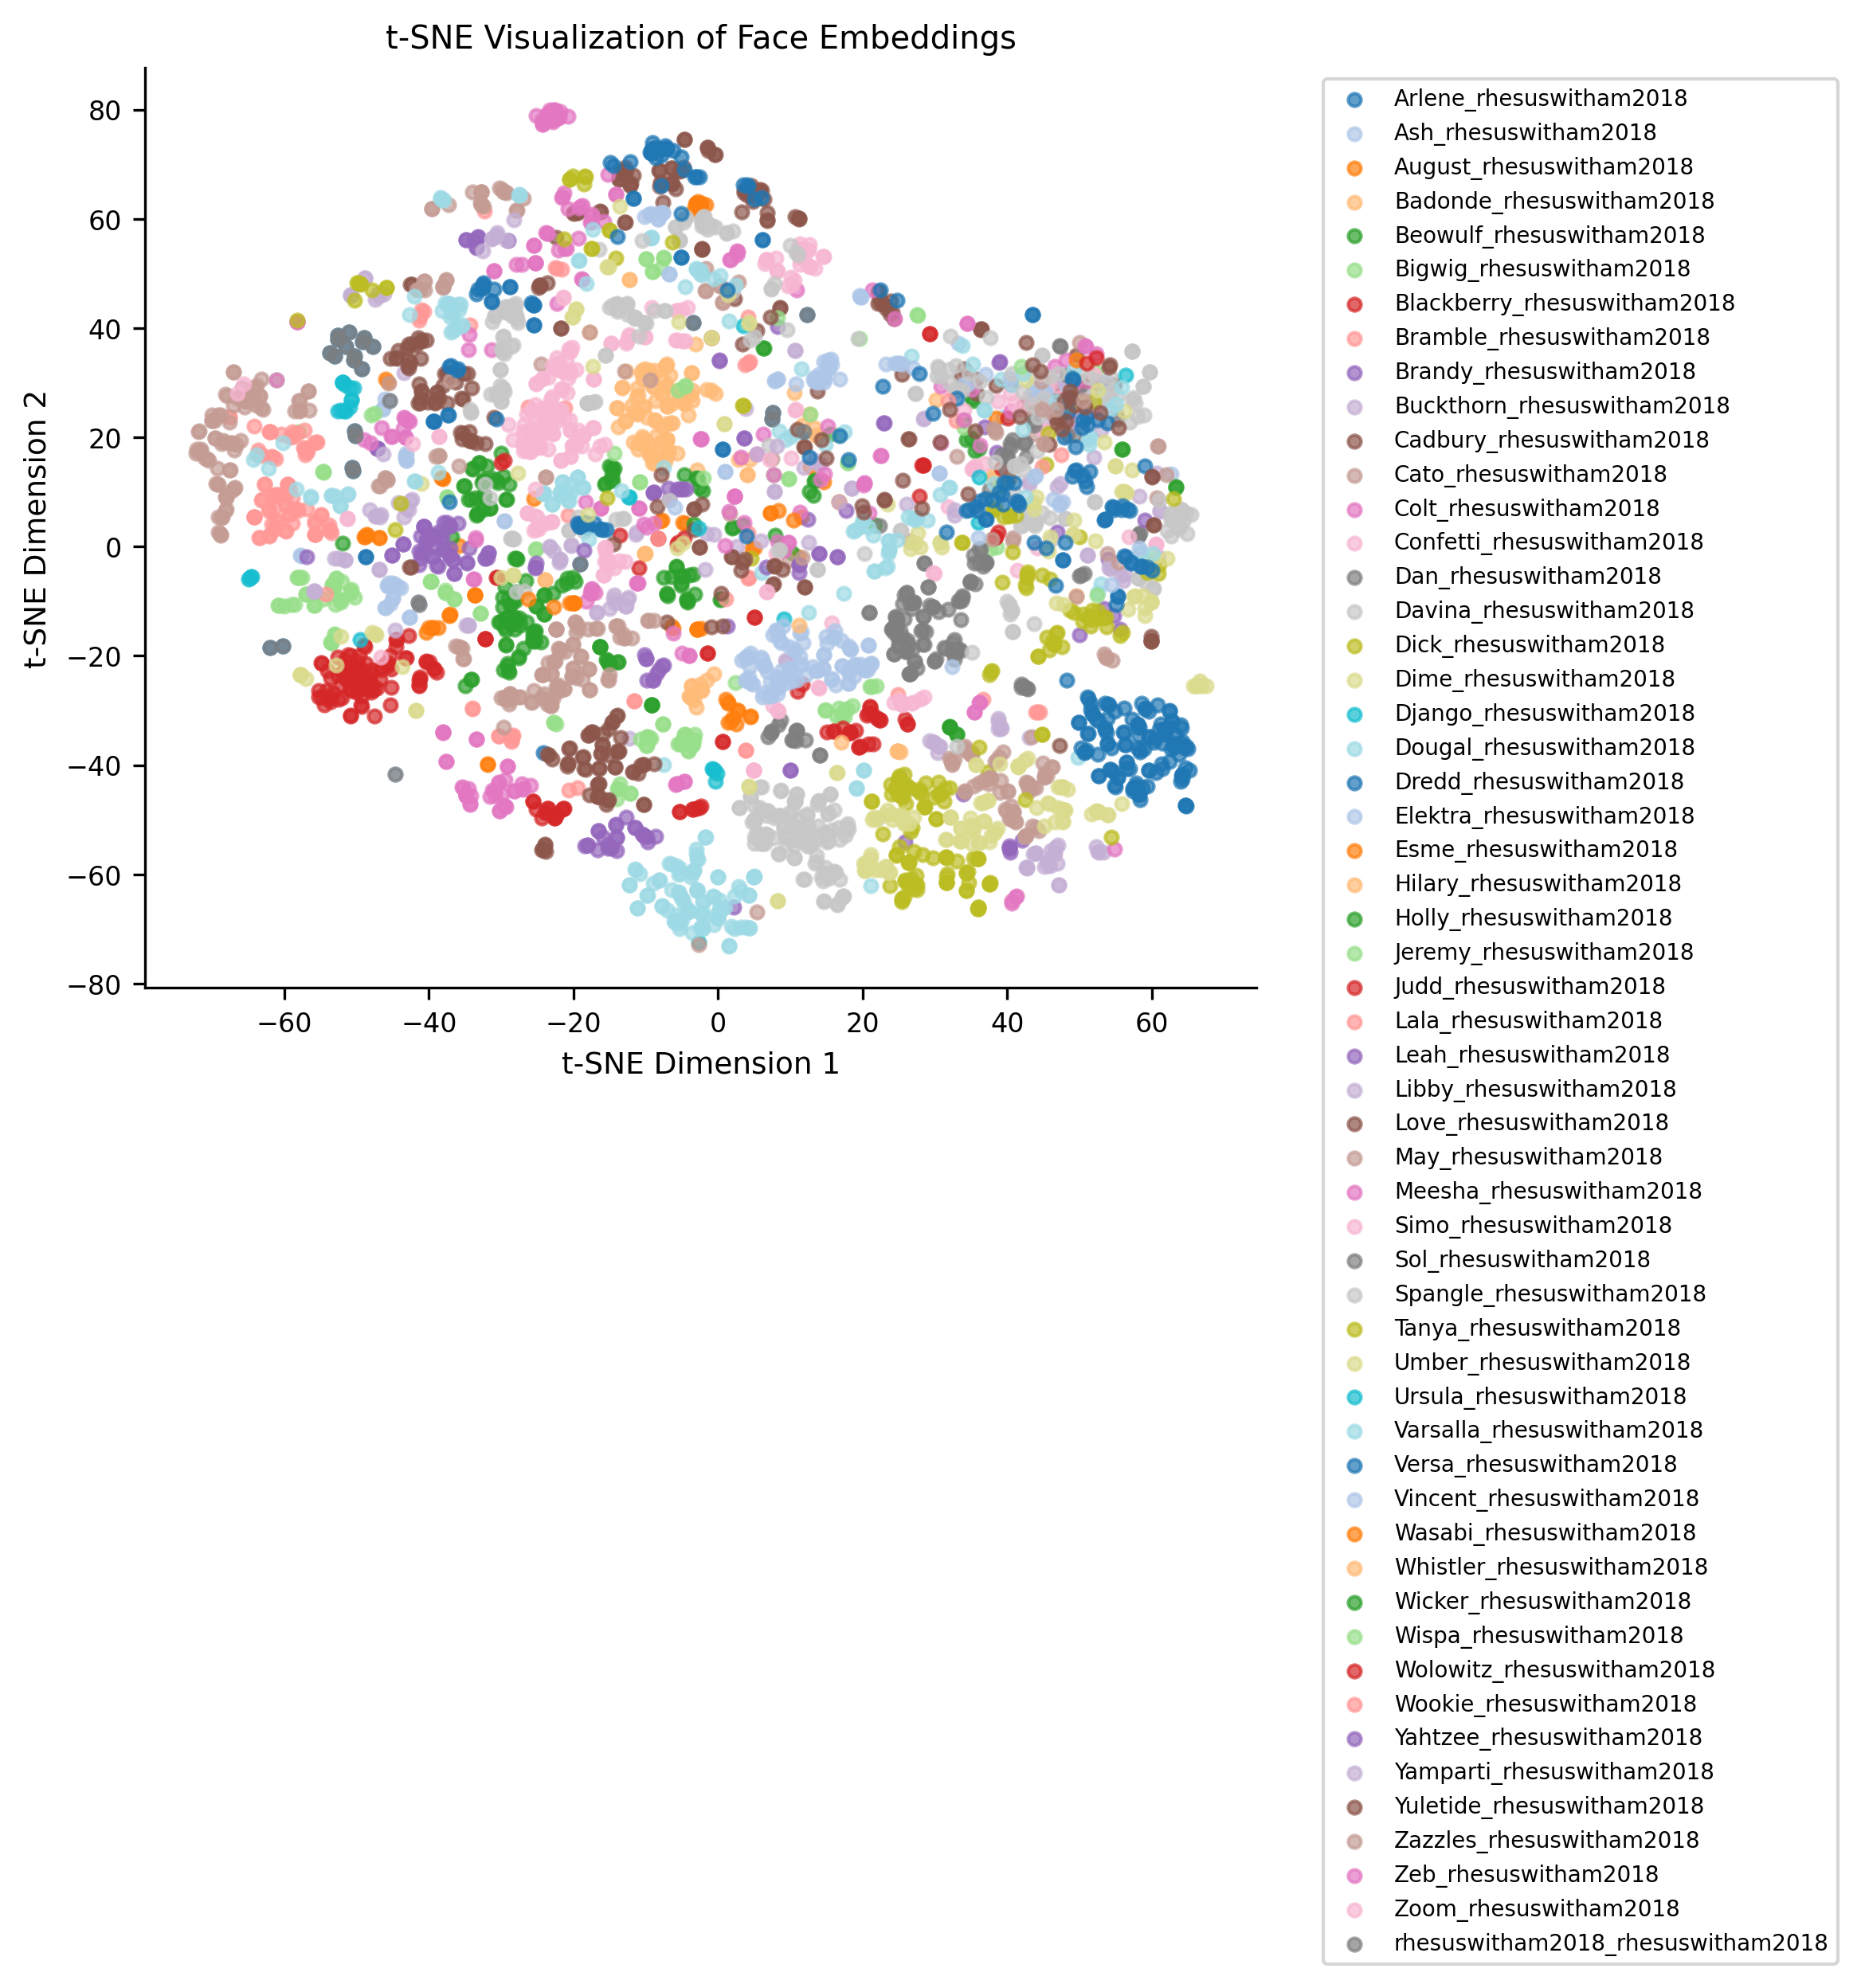

In [ ]:
#@title Display Generated Figures
import glob
from IPython.display import display, Image as IPImage

figure_files = glob.glob(f"{FIGURES_OUTPUT_DIR}/*.png")

if not figure_files:
    print("No figure files found. Please ensure the pipeline in the previous cell ran successfully.")
else:
    for f in sorted(figure_files):
        print(f"\n--- Displaying: {f} ---")
        display(IPImage(filename=f, width=600))

## **6. Summary and Next Steps**

**Congratulations!** You have successfully run a complete face recognition pipeline.

**What we accomplished:**
1.  **Detected, Aligned, and Cropped** faces from your source images.
2.  **Extracted** a unique 512-dimensional embedding for each face.
3.  **Trained** a classifier (SVM or MLP) to identify individuals from these embeddings.
4.  **Evaluated** the classifier's performance and confirmed its validity with a shuffle control experiment.
5.  **Visualized** the results with plots that help interpret the model's behavior.

**Next Steps:**
*   **Explore the Figures**: Analyze the confusion matrix to see which individuals are easily confused. Look at the t-SNE plot to understand the overall separability of your individuals.
*   **Adapt to Your Data**: Use this notebook as a template. Point it to your own datasets, try different MMDetection models from the PrimateFace zoo, or even train a classifier on a larger gallery of known individuals.
*   **Use the Classifier**: The trained `best_clf` object and the `LabelEncoder` (`le`) can be saved and used to predict the identity of new, unseen faces.

## 7. Resources
1. [PrimateFace](https://github.com/PrimateFace/PrimateFace)
2. [mmdetection](https://github.com/open-mmlab/mmdetection)
3. [mmpose](https://github.com/open-mmlab/mmpose)
4. [InsightFace](https://github.com/deepinsight/insightface)